# LLMSteer: The Unreasonable Effectiveness of LLMs in Query Optimization

## Setup

In [55]:
# import packages
import torch
import os.path
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from skops.io import dump
from scipy.stats import gmean
from datetime import datetime
from collections import Counter

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

from models.utils import prepare_data, load_data

In [2]:
job_df = load_data()
job_df.head()

,filename,sql,hint_list,runtime_list,plan_tree,mean_runtime,sd_runtime
0,10a,SELECT MIN(chn.name) AS uncredited_voiced_char...,[23],"[2.533348560333252, 2.5383200645446777, 2.5536...","{'Node Type': 'Aggregate', 'Strategy': 'Plain'...",2.550329,0.016500
1,10a,SELECT MIN(chn.name) AS uncredited_voiced_char...,"[35, 36]","[2.6349778175354004, 2.628606081008911, 2.6323...","{'Node Type': 'Aggregate', 'Strategy': 'Plain'...",2.633306,0.003858
2,10a,SELECT MIN(chn.name) AS uncredited_voiced_char...,"[7, 8, 11, 12, 21, 22, 25, 26]","[1.3421952724456787, 1.328214406967163, 1.3486...","{'Node Type': 'Aggregate', 'Strategy': 'Plain'...",1.338683,0.009532
3,10a,SELECT MIN(chn.name) AS uncredited_voiced_char...,[9],"[3.4522547721862793, 3.441565752029419, 3.3839...","{'Node Type': 'Aggregate', 'Strategy': 'Plain'...",3.449659,0.037371
4,10a,SELECT MIN(chn.name) AS uncredited_voiced_char...,[37],"[4.567062854766846, 4.8856282234191895, 4.5464...","{'Node Type': 'Aggregate', 'Strategy': 'Plain'...",4.619872,0.133072


## Exploratory Data Analysis

### Hints & Latency

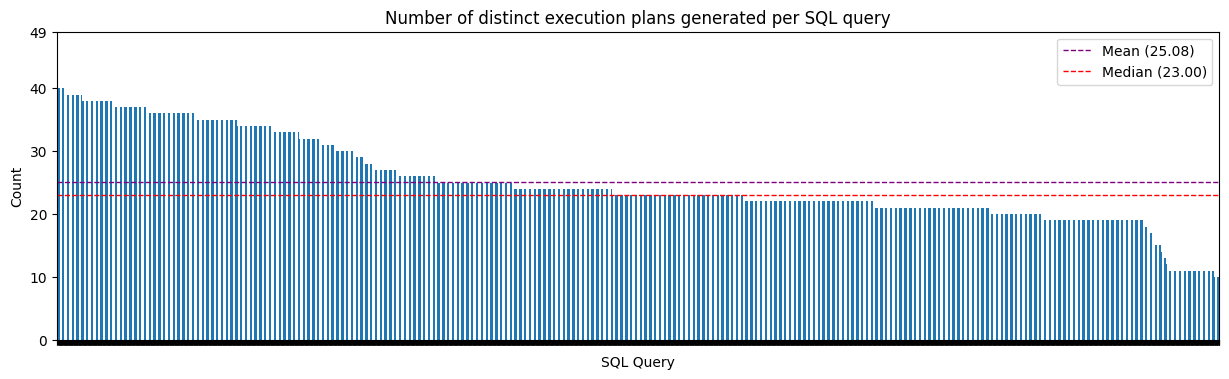

In [3]:
fig, axs = plt.subplots(1, 1, figsize=(15,4))

freq_plt = job_df[['filename', 'plan_tree']].groupby(by='filename', as_index=False)\
    .count()\
    .sort_values(by='plan_tree', ascending=False)\
    .plot(
        kind='bar',
        x='filename',
        y='plan_tree',
        xlabel='SQL Query',
        ylabel='Count',
        title='Number of distinct execution plans generated per SQL query',
        ax=axs
)
freq_plt.axhline(
    y=job_df[['filename', 'plan_tree']].groupby(by='filename', as_index=False).count().plan_tree.mean(),
    color='purple',
    ls='--',
    lw=1
)
freq_plt.axhline(
    y=job_df[['filename', 'plan_tree']].groupby(by='filename', as_index=False).count().plan_tree.median(),
    color='red',
    ls='--',
    lw=1
)

axs.xaxis.set_ticklabels([])
axs.set_ylim([0, job_df.explode(column='hint_list').hint_list.unique().shape[0]])
tcks = axs.get_yticks() 
tcks[-1] = job_df.explode(column='hint_list').hint_list.unique().shape[0]
axs.set_yticks(tcks)
axs.legend([
    f"Mean ({job_df[['filename', 'plan_tree']].groupby(by='filename', as_index=False).count().plan_tree.mean():.2f})",
    f"Median ({job_df[['filename', 'plan_tree']].groupby(by='filename', as_index=False).count().plan_tree.median():.2f})"
])
plt.xticks(fontsize=3)
plt.show()

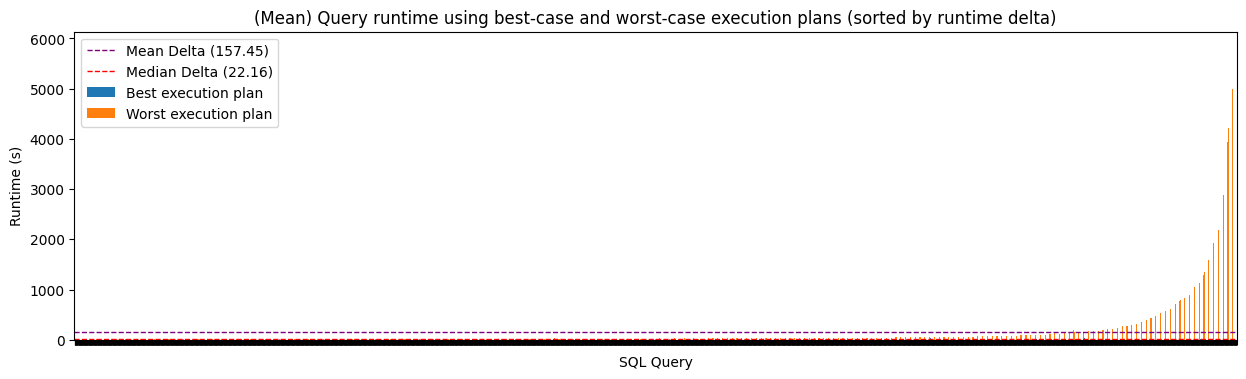

In [4]:
fig, axs = plt.subplots(1, 1, figsize=(15,4))

temp = job_df.groupby(by=['filename'], as_index=False).agg({'mean_runtime': ['min','max']})
temp = temp.iloc[(temp['mean_runtime']['max'] - temp['mean_runtime']['min']).argsort()]

runt_plt = temp.plot.bar(
    ax=axs,
    x='filename',
    xlabel='SQL Query',
    ylabel='Runtime (s)',
    title='(Mean) Query runtime using best-case and worst-case execution plans (sorted by runtime delta)',
)
runt_plt.axhline(
    y=(temp['mean_runtime']['max'] - temp['mean_runtime']['min']).mean(),
    color='purple',
    ls='--',
    lw=1
)
runt_plt.axhline(
    y=(temp['mean_runtime']['max'] - temp['mean_runtime']['min']).median(),
    color='red',
    ls='--',
    lw=1
)

axs.xaxis.set_ticklabels([])
axs.legend([
    f"Mean Delta ({(temp['mean_runtime']['max'] - temp['mean_runtime']['min']).mean():.2f})", 
    f"Median Delta ({(temp['mean_runtime']['max'] - temp['mean_runtime']['min']).median():.2f})",
    'Best execution plan', 
    'Worst execution plan'
])
plt.xticks(fontsize=3)
plt.show()

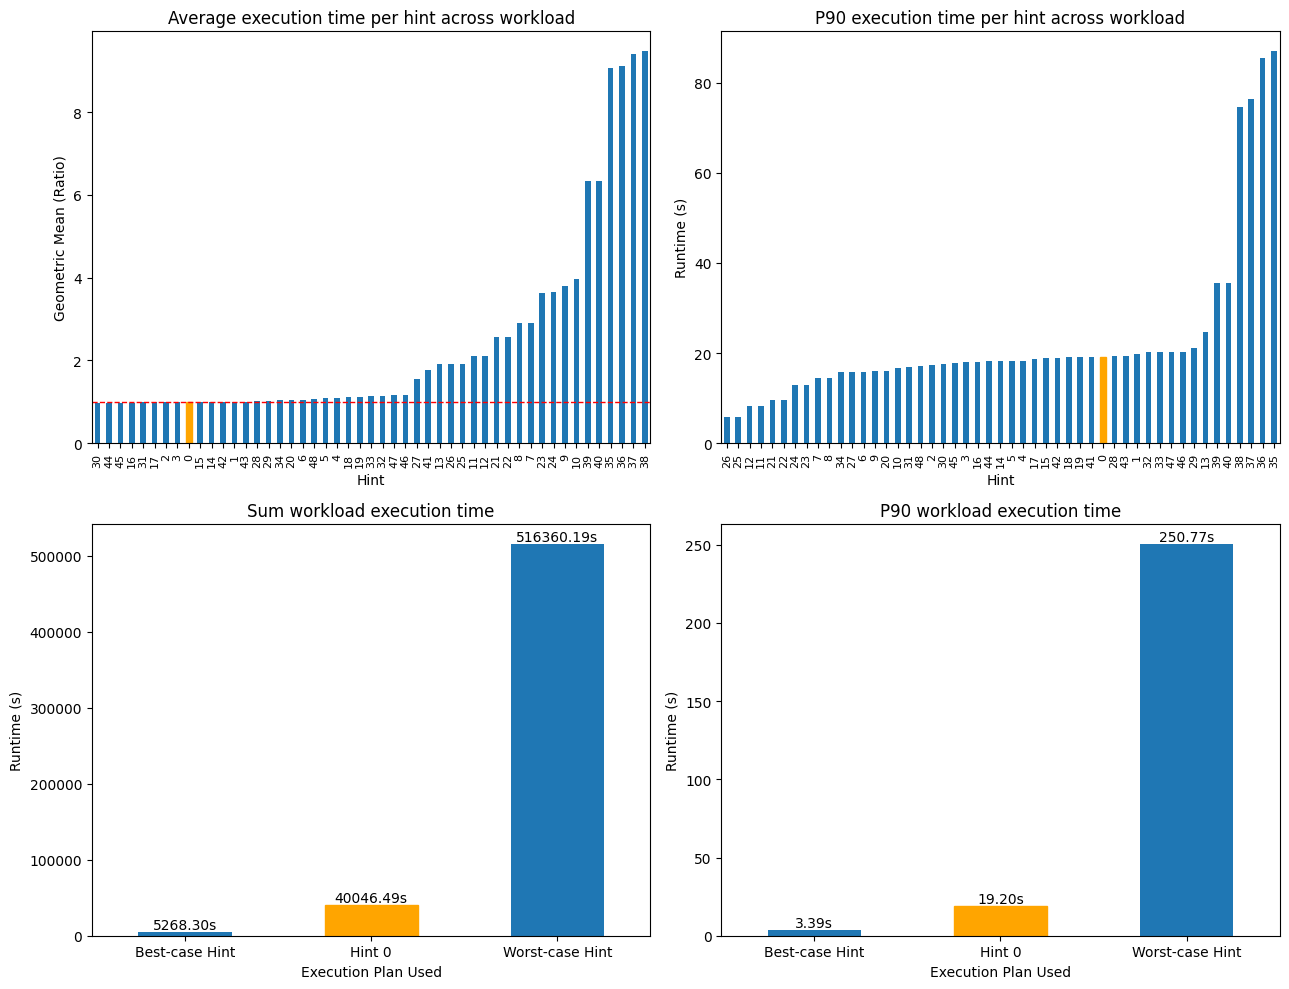

In [5]:
fig, axs = plt.subplots(2,2, figsize=(13,10))

hint_runtimes_df = job_df[['hint_list', 'mean_runtime']].explode(column='hint_list').sort_values(
    by='hint_list'
)

# compute geomean of ratio between hint x and hint 0
geo_df = hint_runtimes_df.copy()
geo_df['mean_runtime'] = geo_df.mean_runtime.values / pd.concat([
    geo_df.loc[geo_df.hint_list == 0, 'mean_runtime']
]*geo_df.hint_list.unique().shape[0]).values
geo_df = geo_df.reset_index(drop=True)
geo_df = geo_df.groupby(by='hint_list', as_index=False).agg({'mean_runtime': gmean}).sort_values(by='mean_runtime')
geo_df.plot.bar(
    ax=axs[0][0],
    x='hint_list',
    title='Average execution time per hint across workload',
    ylabel='Geometric Mean (Ratio)',
    xlabel='Hint'
)
axs[0][0].set_xticklabels(axs[0][0].get_xticklabels(), fontdict={'fontsize': '8'})
axs[0][0].get_legend().remove()
axs[0][0].get_children()[8].set_color('orange')
axs[0][0].axhline(
    y=1,
    color='red',
    ls='--',
    lw=1,
)

# P90
hint_runtimes_df.groupby(by=['hint_list'], as_index=False)['mean_runtime'].quantile(q=0.9).sort_values(
    by='mean_runtime', 
    ascending=True,
).plot.bar(
    ax=axs[0][1],
    x='hint_list',
    title='P90 execution time per hint across workload',
    ylabel='Runtime (s)',
    xlabel='Hint'
)
axs[0][1].set_xticklabels(axs[0][1].get_xticklabels(), fontdict={'fontsize': '8'})
axs[0][1].get_legend().remove()
axs[0][1].get_children()[33].set_color('orange')


# sum workload execution time
pd.concat([
    job_df.groupby(by=['filename']).agg({'mean_runtime': ['min', 'max']}).sum(axis=0).reset_index(level=0, drop=True),
    pd.Series([job_df.explode(column='hint_list').loc[job_df.explode(column='hint_list').hint_list == 0, 'mean_runtime'].sum()], index=['hint0'])
]).sort_values().plot.bar(
    ax=axs[1][0],
    title='Sum workload execution time',
    ylabel='Runtime (s)',
    xlabel='Execution Plan Used'
    
)
axs[1][0].set_xticklabels(['Best-case Hint', 'Hint 0', 'Worst-case Hint'])
axs[1][0].bar_label(axs[1][0].containers[0], fmt='{:.2f}s')
axs[1][0].set_xticklabels(axs[1][0].get_xticklabels(), rotation=0)
axs[1][0].get_children()[1].set_color('orange')

# p90 workload execution time
pd.concat([
    job_df.groupby(by=['filename']).agg({'mean_runtime': ['min', 'max']}).quantile(q=0.9).reset_index(drop=True, level=0),
    pd.Series([job_df.explode(column='hint_list').loc[job_df.explode(column='hint_list').hint_list == 0, 'mean_runtime'].quantile(0.9)], index=['hint0'])
]).sort_values().plot.bar(
    ax=axs[1][1],
    title='P90 workload execution time',
    ylabel='Runtime (s)',
    xlabel='Execution Plan Used'
)
axs[1][1].set_xticklabels(['Best-case Hint', 'Hint 0', 'Worst-case Hint'])
axs[1][1].bar_label(axs[1][1].containers[0], fmt='{:.2f}s')
axs[1][1].set_xticklabels(axs[1][1].get_xticklabels(), rotation=0)
axs[1][1].get_children()[1].set_color('orange')

plt.tight_layout()
plt.show()

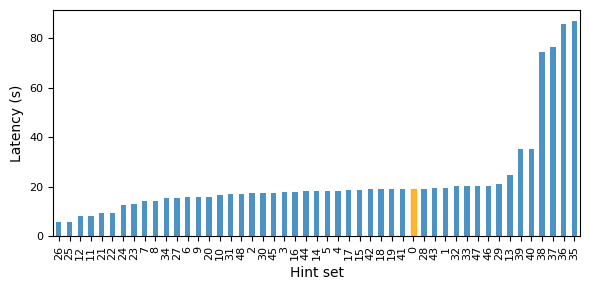

In [6]:
fig, axs = plt.subplots(figsize=(6,3))
warnings.filterwarnings('ignore')

hint_runtimes_df.groupby(by=['hint_list'], as_index=False)['mean_runtime'].quantile(q=0.9).sort_values(
    by='mean_runtime', 
    ascending=True,
).plot.bar(
    ax=axs,
    x='hint_list',
    xlabel='',
    alpha=0.8,
)

axs.set_ylabel('Latency (s)')
axs.set_xlabel('Hint set')
axs.set_xticklabels(axs.get_xticklabels(), fontdict={'fontsize': '8'})
axs.set_yticklabels(axs.get_yticklabels(), fontdict={'fontsize': '8'})

axs.get_legend().remove()
axs.get_children()[33].set_color('orange')

plt.tight_layout()
plt.show()

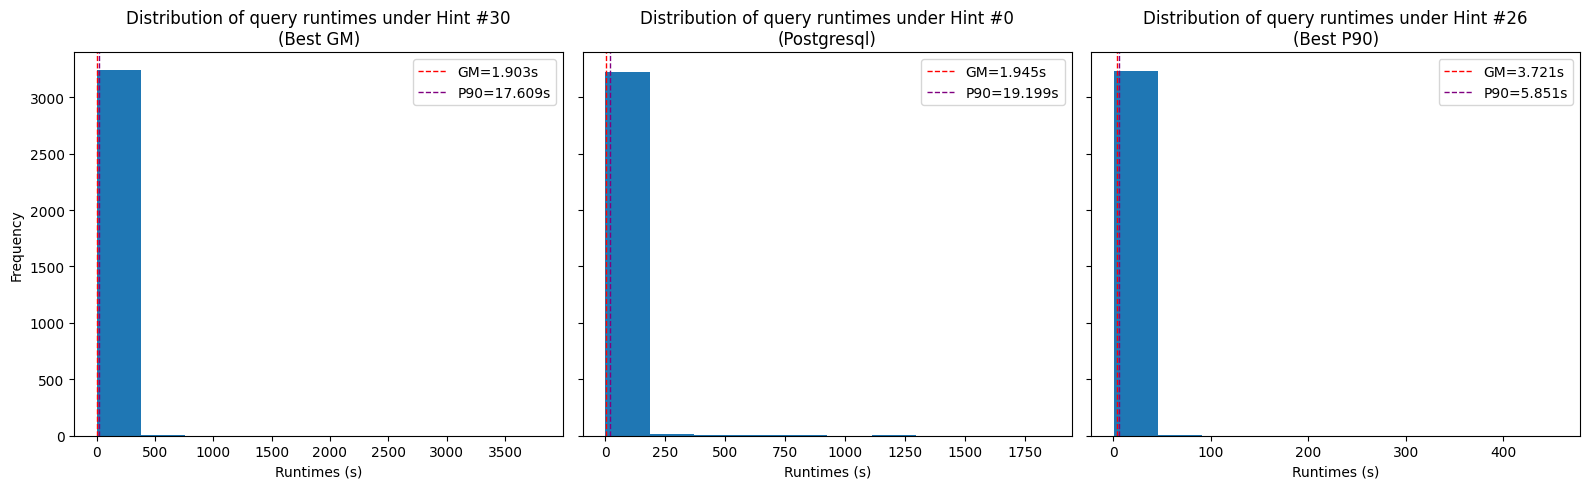

In [7]:
fig, axs = plt.subplots(1,3, figsize=(16,5), sharey=True)
warnings.filterwarnings('ignore')

hint_runtimes_df.loc[hint_runtimes_df.hint_list == 30, 'mean_runtime'].plot.hist(
    ax=axs[0],
    xlabel='Runtimes (s)',
    title='Distribution of query runtimes under Hint #30\n(Best GM)'
)
axs[0].axvline(
    x=gmean(hint_runtimes_df.loc[hint_runtimes_df.hint_list == 30, 'mean_runtime']),
    color='red',
    ls='--',
    lw=1,
)
axs[0].axvline(
    x=hint_runtimes_df.loc[hint_runtimes_df.hint_list == 30, 'mean_runtime'].quantile(q=0.9),
    color='purple',
    ls='--',
    lw=1,
)
axs[0].legend([
    '_',
    f"GM={gmean(hint_runtimes_df.loc[hint_runtimes_df.hint_list == 30, 'mean_runtime']):.3f}s", 
    f"P90={hint_runtimes_df.loc[hint_runtimes_df.hint_list == 30, 'mean_runtime'].quantile(q=0.9):.3f}s"
])

hint_runtimes_df.loc[hint_runtimes_df.hint_list == 0, 'mean_runtime'].plot.hist(
    ax=axs[1],
    xlabel='Runtimes (s)',
    title='Distribution of query runtimes under Hint #0\n(Postgresql)'
)
axs[1].axvline(
    x=gmean(hint_runtimes_df.loc[hint_runtimes_df.hint_list == 0, 'mean_runtime']),
    color='red',
    ls='--',
    lw=1,
)
axs[1].axvline(
    x=hint_runtimes_df.loc[hint_runtimes_df.hint_list == 0, 'mean_runtime'].quantile(q=0.9),
    color='purple',
    ls='--',
    lw=1,
)
axs[1].legend([
    '_',
    f"GM={gmean(hint_runtimes_df.loc[hint_runtimes_df.hint_list == 0, 'mean_runtime']):.3f}s", 
    f"P90={hint_runtimes_df.loc[hint_runtimes_df.hint_list == 0, 'mean_runtime'].quantile(q=0.9):.3f}s"
])

hint_runtimes_df.loc[hint_runtimes_df.hint_list == 26, 'mean_runtime'].plot.hist(
    ax=axs[2],
    xlabel='Runtimes (s)',
    title='Distribution of query runtimes under Hint #26\n(Best P90)'
)
axs[2].axvline(
    x=gmean(hint_runtimes_df.loc[hint_runtimes_df.hint_list == 26, 'mean_runtime']),
    color='red',
    ls='--',
    lw=1,
)
axs[2].axvline(
    x=hint_runtimes_df.loc[hint_runtimes_df.hint_list == 26, 'mean_runtime'].quantile(q=0.9),
    color='purple',
    ls='--',
    lw=1,
)
axs[2].legend([
    '_',
    f"GM={gmean(hint_runtimes_df.loc[hint_runtimes_df.hint_list == 26, 'mean_runtime']):.3f}s", 
    f"P90={hint_runtimes_df.loc[hint_runtimes_df.hint_list == 26, 'mean_runtime'].quantile(q=0.9):.3f}s"
])

plt.tight_layout()
plt.show()

### Embeddings & PCA

In [8]:
X, hint_l, opt_l, targets_l = prepare_data(job_df, './embeddings', f'syntaxA_embedding', False)
components = 120
pipeline_viz = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA())
])

X_viz = torch.Tensor(pipeline_viz.fit_transform(X))[:,:components]

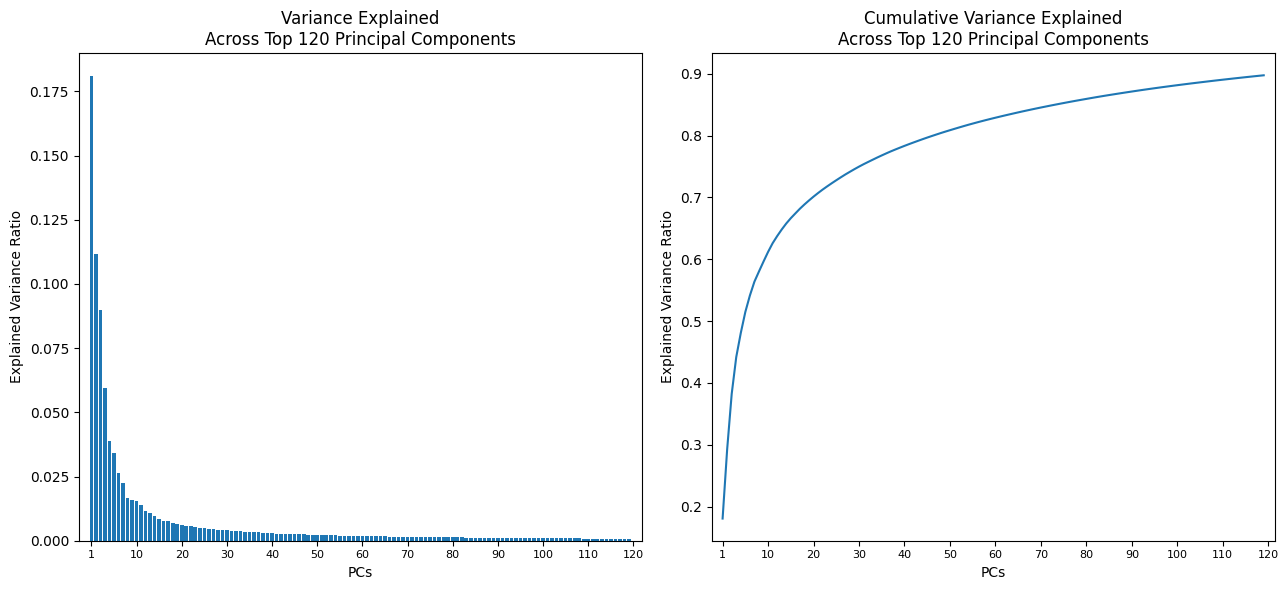

In [9]:
fig, axs = plt.subplots(1,2, figsize=(13,6))

axs[0].bar(
    x = np.arange(components), 
    height=pipeline_viz.named_steps.get('pca').explained_variance_ratio_[:components],
)
axs[0].set_xticks(range(0, components+1, 10), [1] + list(range(10, components+1, 10)), fontdict={'fontsize': '8'})
axs[0].set_xlabel('PCs')
axs[0].set_ylabel('Explained Variance Ratio')
axs[0].set_title(f'Variance Explained\nAcross Top {components} Principal Components')
axs[0].margins(x=0.02, tight=True)

axs[1].plot(
    np.cumsum(pipeline_viz.named_steps.get('pca').explained_variance_ratio_)[:components],
)
axs[1].set_xticks(range(0, components+1, 10), [1] + list(range(10, components+1, 10)), fontdict={'fontsize': '8'})
axs[1].set_xlabel('PCs')
axs[1].set_ylabel('Explained Variance Ratio')
axs[1].set_title(f'Cumulative Variance Explained\nAcross Top {components} Principal Components')
axs[1].margins(x=0.02, tight=True)

plt.tight_layout()
plt.show()

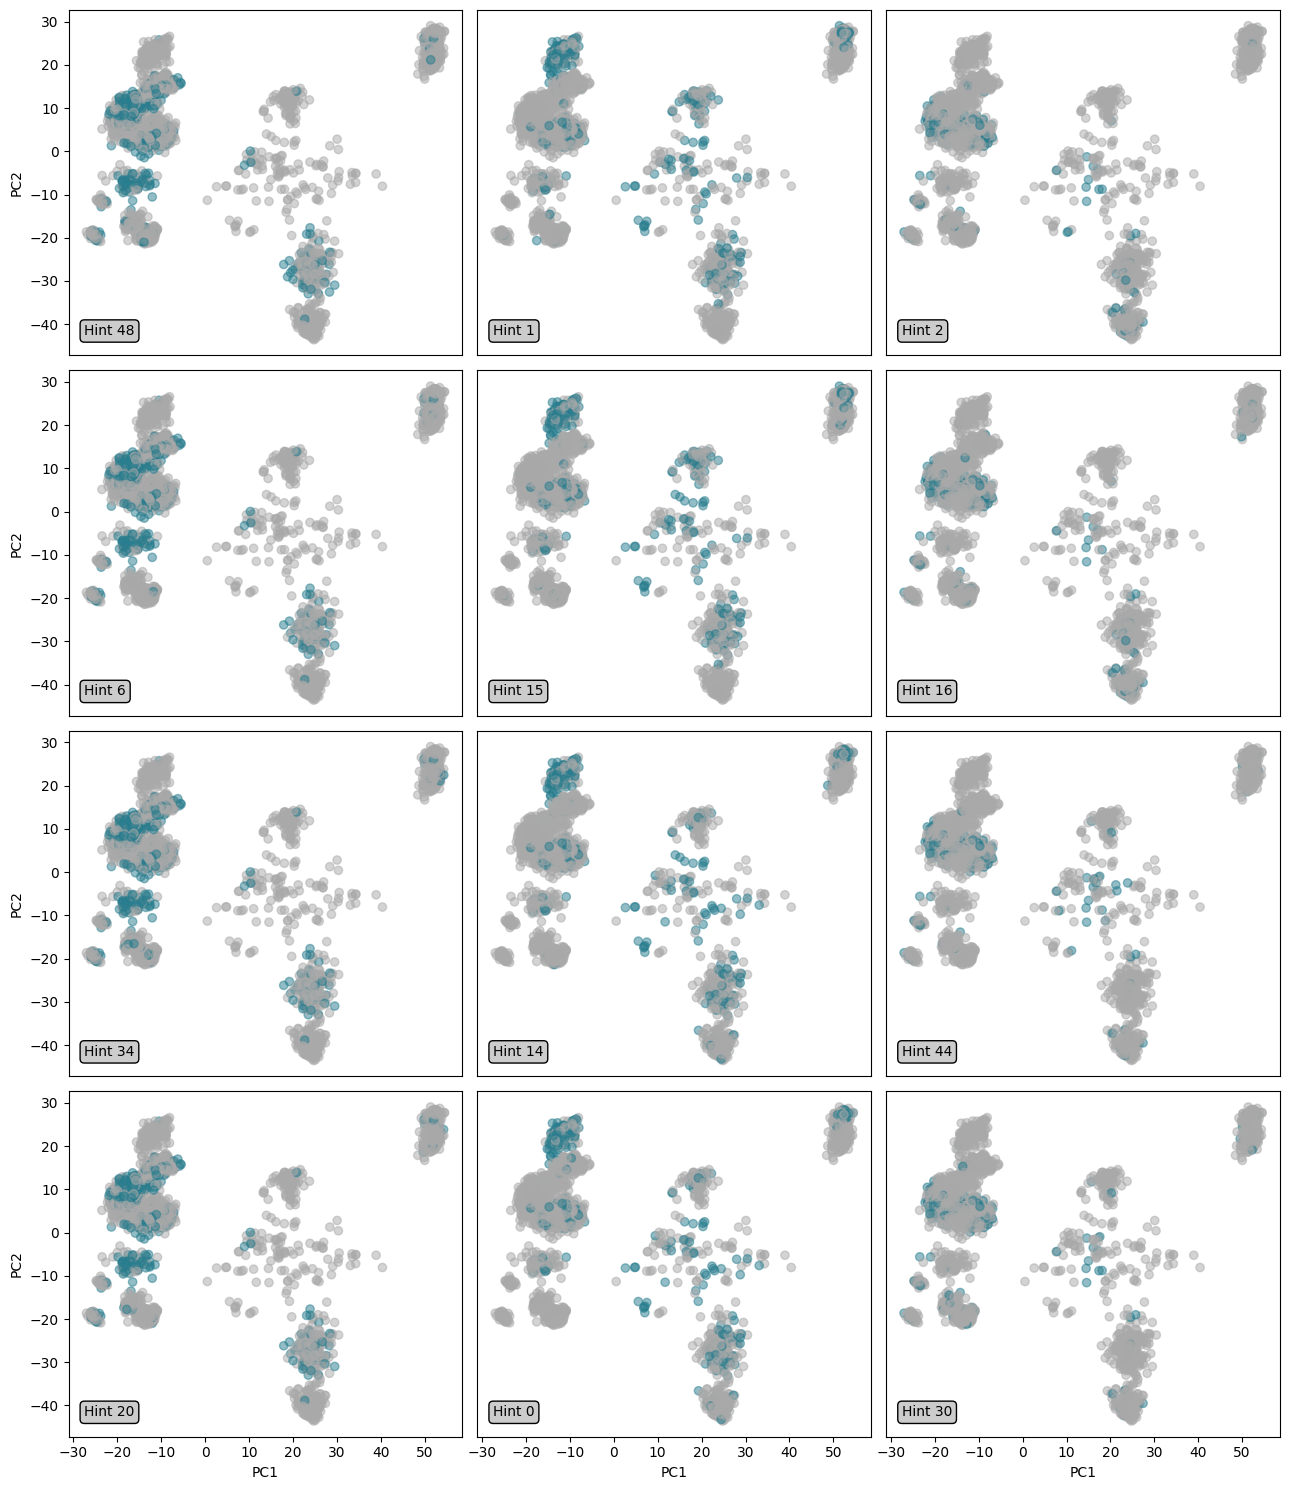

In [10]:
k = 12
GREY = 'darkgrey'
top_k = pd.Series(torch.where(hint_l == opt_l)[1]).value_counts()[:k].index.to_numpy().reshape((4,3))

fig, axs = plt.subplots(4,3, figsize=(13,15))
axs[2][0], axs[3][0], axs[0][1], axs[0][2] = axs[0][1], axs[0][2], axs[2][0], axs[3][0]
axs[2][1], axs[3][0] = axs[3][0], axs[2][1]

for idx_i, ax_row in enumerate(axs):
    for idx_j, ax in enumerate(ax_row):
        cmap = np.array(['#287D8EFF']*X_viz.size(0))
        cmap[~(hint_l == opt_l)[:, top_k[idx_i, idx_j]]] = GREY

        ax.scatter(
            x=X_viz[:,0], 
            y=X_viz[:,1], 
            alpha=0.5,
            c=cmap,
        )
        
        if top_k[idx_i, idx_j] not in {48,6,34,20}:
            ax.get_yaxis().set_visible(False)
        else:
            ax.set_ylabel('PC2')
        if top_k[idx_i, idx_j] not in {20,0,30}:
            ax.get_xaxis().set_visible(False)
        else:
            ax.set_xlabel('PC1')

        ax.annotate(f"Hint {top_k[idx_i, idx_j]}", (-27.5,-42.5), bbox=dict(boxstyle="round", fc="0.8"))

plt.tight_layout()
plt.show()


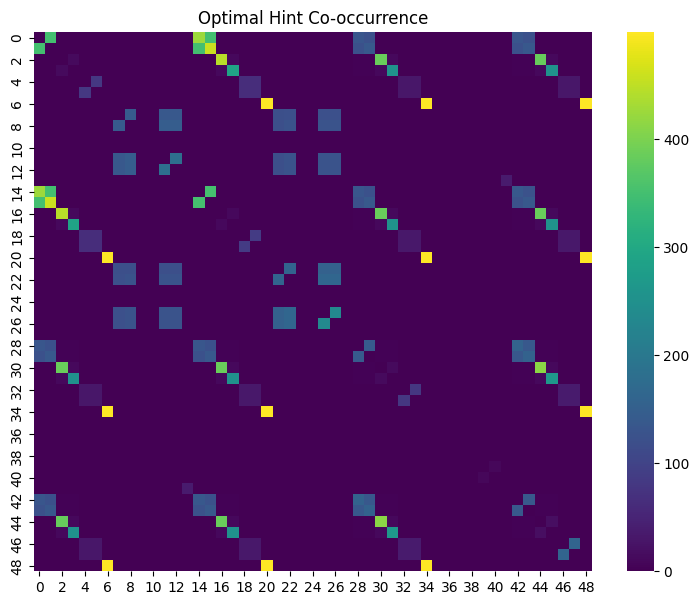

In [11]:
fig, axs = plt.subplots(1,1, figsize=(9,7))

sns.heatmap(
    ((hint_l == opt_l).type(torch.int).T @ (hint_l == opt_l).type(torch.int)).fill_diagonal_(0),
    cmap='viridis',
    ax=axs,
)
axs.set_title('Optimal Hint Co-occurrence')
plt.show()

## LLMSteer vs. PostgreSQL

In [12]:
print(
    f"The apriori distribution indicates that "
    f"{(job_df.explode(column='hint_list').loc[(job_df.explode(column='hint_list').hint_list == 0), ['filename', 'hint_list', 'mean_runtime']].sort_values(by='filename').set_index('filename')['mean_runtime'] < job_df.explode(column='hint_list').loc[(job_df.explode(column='hint_list').hint_list == 26), ['filename', 'hint_list', 'mean_runtime']].sort_values(by='filename').set_index('filename')['mean_runtime']).sum() * 100 / job_df.filename.unique().shape[0]:.2f}%"
    f" of queries\n run faster under Hint 0 which is the benchmark hint (postgres)"
)

The apriori distribution indicates that 69.29% of queries
 run faster under Hint 0 which is the benchmark hint (postgres)


In [13]:
RANDOM_SEED = 24508
THRESHOLD = 0.5

original_sql, hint_l, opt_l, targets_l, spaced_sql, tabbed_sql = prepare_data(job_df, './embeddings', f'syntaxA_embedding', True, augment=True)
p = 0.8
k = 10

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA())
])
scaler = StandardScaler()

model_cfgs = [
    { 'name': 'LRG-5-False', 'estimator': LogisticRegression(random_state=RANDOM_SEED, max_iter=1000), 'pcs': 5 , 'scale': False},
    { 'name': 'SVC_RBF-5-False', 'estimator': SVC(random_state=RANDOM_SEED, kernel='rbf'), 'pcs': 5 , 'scale': False},
    { 'name': 'SVC_LIN-5-False', 'estimator': SVC(random_state=RANDOM_SEED, kernel='linear'), 'pcs': 5 , 'scale': False},
    { 'name': 'GBC-5-False', 'estimator': GradientBoostingClassifier(random_state=RANDOM_SEED, n_estimators=500, learning_rate=0.1), 'pcs': 5 , 'scale': False},
    { 'name': 'RFC-5-False', 'estimator': RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=100), 'pcs': 5 , 'scale': False},
    { 'name': 'LRG-50-False', 'estimator': LogisticRegression(random_state=RANDOM_SEED, max_iter=1000), 'pcs': 50 , 'scale': False},
    { 'name': 'SVC_RBF-50-False', 'estimator': SVC(random_state=RANDOM_SEED, kernel='rbf'), 'pcs': 50 , 'scale': False},
    { 'name': 'SVC_LIN-50-False', 'estimator': SVC(random_state=RANDOM_SEED, kernel='linear'), 'pcs': 50 , 'scale': False},
    { 'name': 'GBC-50-False', 'estimator': GradientBoostingClassifier(random_state=RANDOM_SEED, n_estimators=500, learning_rate=0.1), 'pcs': 50 , 'scale': False},
    { 'name': 'RFC-50-False', 'estimator': RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=100), 'pcs': 50 , 'scale': False},
    { 'name': 'LRG-120-False', 'estimator': LogisticRegression(random_state=RANDOM_SEED, max_iter=1000), 'pcs': 120 , 'scale': False},
    { 'name': 'SVC_RBF-120-False', 'estimator': SVC(random_state=RANDOM_SEED, kernel='rbf'), 'pcs': 120 , 'scale': False},
    { 'name': 'SVC_LIN-120-False', 'estimator': SVC(random_state=RANDOM_SEED, kernel='linear'), 'pcs': 120 , 'scale': False},
    { 'name': 'GBC-120-False', 'estimator': GradientBoostingClassifier(random_state=RANDOM_SEED, n_estimators=500, learning_rate=0.1), 'pcs': 120 , 'scale': False},
    { 'name': 'RFC-120-False', 'estimator': RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=100), 'pcs': 120 , 'scale': False},
    { 'name': 'LRG-5-True', 'estimator': LogisticRegression(random_state=RANDOM_SEED, max_iter=1000), 'pcs': 5, 'scale': True},
    { 'name': 'SVC_RBF-5-True', 'estimator': SVC(random_state=RANDOM_SEED, kernel='rbf'), 'pcs': 5, 'scale': True},
    { 'name': 'SVC_LIN-5-True', 'estimator': SVC(random_state=RANDOM_SEED, kernel='linear'), 'pcs': 5, 'scale': True},
    { 'name': 'GBC-5-True', 'estimator': GradientBoostingClassifier(random_state=RANDOM_SEED, n_estimators=500, learning_rate=0.1), 'pcs': 5, 'scale': True},
    { 'name': 'RFC-5-True', 'estimator': RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=100), 'pcs': 5, 'scale': True},
    { 'name': 'LRG-50-True', 'estimator': LogisticRegression(random_state=RANDOM_SEED, max_iter=1000), 'pcs': 50, 'scale': True},
    { 'name': 'SVC_RBF-50-True', 'estimator': SVC(random_state=RANDOM_SEED, kernel='rbf'), 'pcs': 50, 'scale': True},
    { 'name': 'SVC_LIN-50-True', 'estimator': SVC(random_state=RANDOM_SEED, kernel='linear'), 'pcs': 50, 'scale': True},
    { 'name': 'GBC-50-True', 'estimator': GradientBoostingClassifier(random_state=RANDOM_SEED, n_estimators=500, learning_rate=0.1), 'pcs': 50, 'scale': True},
    { 'name': 'RFC-50-True', 'estimator': RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=100), 'pcs': 50, 'scale': True},
    { 'name': 'LRG-120-True', 'estimator': LogisticRegression(random_state=RANDOM_SEED, max_iter=1000), 'pcs': 120, 'scale': True},
    { 'name': 'SVC_RBF-120-True', 'estimator': SVC(random_state=RANDOM_SEED, kernel='rbf'), 'pcs': 120, 'scale': True},
    { 'name': 'SVC_LIN-120-True', 'estimator': SVC(random_state=RANDOM_SEED, kernel='linear'), 'pcs': 120, 'scale': True},
    { 'name': 'GBC-120-True', 'estimator': GradientBoostingClassifier(random_state=RANDOM_SEED, n_estimators=500, learning_rate=0.1), 'pcs': 120, 'scale': True},
    { 'name': 'RFC-120-True', 'estimator': RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=100), 'pcs': 120, 'scale': True},
]
for cfg in model_cfgs:
    # classification metrics
    cfg['model_train_accuracy'] = list()
    cfg['model_test_accuracy'] = list()
    cfg['model_train_recall'] = list()
    cfg['model_test_recall'] = list()
    cfg['model_train_precision'] = list()
    cfg['model_test_precision'] = list()
    cfg['model_train_f1score'] = list()
    cfg['model_test_f1score'] = list()
    cfg['model_train_auroc'] = list()
    cfg['model_test_auroc'] = list()
    
    cfg['apriori_train_distribution'] = list()
    cfg['apriori_test_distribution'] = list()

    # hint steering strategy performance
    cfg['train_model_workload'] = list()
    cfg['train_opt_workload'] = list()
    cfg['train_benchmark_workload'] = list()
    cfg['train_apriori_workload'] = list()
    cfg['test_model_workload'] = list()
    cfg['test_opt_workload'] = list()
    cfg['test_benchmark_workload'] = list()
    cfg['test_apriori_workload'] = list()

    cfg['train_model_p90'] = list()
    cfg['train_opt_p90'] = list()
    cfg['train_benchmark_p90'] = list()
    cfg['train_apriori_p90'] = list()
    cfg['test_model_p90'] = list()
    cfg['test_opt_p90'] = list()
    cfg['test_benchmark_p90'] = list()
    cfg['test_apriori_p90'] = list()

    cfg['train_model_median'] = list()
    cfg['train_opt_median'] = list()
    cfg['train_benchmark_median'] = list()
    cfg['train_apriori_median'] = list()
    cfg['test_model_median'] = list()
    cfg['test_opt_median'] = list()
    cfg['test_benchmark_median'] = list()
    cfg['test_apriori_median'] = list()

    # robustness
    cfg['model_spaced_accuracy'] = list()
    cfg['model_spaced_recall'] = list()
    cfg['model_spaced_precision'] = list()
    cfg['model_spaced_f1score'] = list()
    cfg['model_spaced_auroc'] = list()
    cfg['model_spaced_workload'] = list()
    cfg['model_spaced_p90'] = list()
    cfg['model_spaced_median'] = list()

    cfg['model_tabbed_accuracy'] = list()
    cfg['model_tabbed_recall'] = list()
    cfg['model_tabbed_precision'] = list()
    cfg['model_tabbed_f1score'] = list()
    cfg['model_tabbed_auroc'] = list()
    cfg['model_tabbed_workload'] = list()
    cfg['model_tabbed_p90'] = list()
    cfg['model_tabbed_median'] = list()


for i, (train_idx, test_idx) in enumerate(StratifiedShuffleSplit(n_splits=k, train_size=p, random_state=RANDOM_SEED).split(original_sql, targets_l)):
    print(f'[{datetime.now().isoformat()}] Beginning experiments in CV fold {i+1}')
    X_train, X_test, y_train, y_test = original_sql[train_idx].numpy(), original_sql[test_idx].numpy(), targets_l[train_idx].numpy(), targets_l[test_idx].numpy()
    X_train = pipeline.fit_transform(X_train)
    X_test = pipeline.transform(X_test)

    X_spaced_test = pipeline.transform(spaced_sql[test_idx].numpy())
    X_tabbed_test = pipeline.transform(tabbed_sql[test_idx].numpy())

    weights = {
        0: ((targets_l[train_idx].type(torch.long) == 1).sum() / (targets_l[train_idx].type(torch.long) == 0).sum()).item(), 
        1: ((targets_l[train_idx].type(torch.long) == 0).sum() / (targets_l[train_idx].type(torch.long) == 1).sum()).item() 
    }

    benchmark_const = torch.LongTensor([0])
    longtail_const = torch.LongTensor([26])

    apriori_train_distribution = (y_train.shape[0] - y_train.sum())/y_train.shape[0]
    apriori_test_distribution = (y_test.shape[0] - y_test.sum())/y_test.shape[0]
    apriori_train_runtimes = hint_l[train_idx].gather(1, torch.where(torch.Tensor(y_train) > THRESHOLD, longtail_const, benchmark_const).view(-1,1))
    apriori_test_runtimes = hint_l[test_idx].gather(1, torch.where(torch.Tensor(y_test) > THRESHOLD, longtail_const, benchmark_const).view(-1,1))

    train_opt_workload = opt_l[train_idx].mean(dim=1).sum()
    train_benchmark_workload = hint_l[train_idx,0].sum()
    train_apriori_workload = apriori_train_runtimes.sum()
    test_opt_workload = opt_l[test_idx].mean(dim=1).sum()
    test_benchmark_workload = hint_l[test_idx,0].sum()
    test_apriori_workload = apriori_test_runtimes.sum()

    train_opt_p90 = opt_l[train_idx].mean(dim=1).quantile(0.90)
    train_benchmark_p90 = hint_l[train_idx,0].quantile(0.90)
    train_apriori_p90 = apriori_train_runtimes.quantile(0.90)
    test_opt_p90 = opt_l[test_idx].mean(dim=1).quantile(0.90)
    test_benchmark_p90 = hint_l[test_idx,0].quantile(0.90)
    test_apriori_p90 = apriori_test_runtimes.quantile(0.90)

    train_opt_median = opt_l[train_idx].mean(dim=1).median()
    train_benchmark_median = hint_l[train_idx,0].median()
    train_apriori_median = apriori_train_runtimes.median()
    test_opt_median = opt_l[test_idx].mean(dim=1).median()
    test_benchmark_median = hint_l[test_idx,0].median()
    test_apriori_median = apriori_test_runtimes.median()

    for cfg in model_cfgs:
        print(f'[{datetime.now().isoformat()}] Beginning to Train {cfg["name"]} Model')
        PCS = cfg['pcs']

        if cfg['scale']:
            X_train_f = scaler.fit_transform(X_train)
            X_test_f = scaler.transform(X_test)
            X_spaced_test_f = scaler.transform(X_spaced_test)
            X_tabbed_test_f = scaler.transform(X_tabbed_test)
        else:
            X_train_f = X_train.copy()
            X_test_f = X_test.copy()
            X_spaced_test_f = X_spaced_test.copy()
            X_tabbed_test_f = X_tabbed_test.copy()


        if hasattr(cfg['estimator'], 'class_weight'):
            cfg['estimator'].class_weight = weights.copy()

        cfg['estimator'].fit(X_train_f[:,:cfg['pcs']], y_train)
        y_train_pred = cfg['estimator'].predict(X_train_f[:,:PCS])
        y_test_pred = cfg['estimator'].predict(X_test_f[:,:PCS])
        
        y_spaced_pred = cfg['estimator'].predict(X_spaced_test_f[:,:PCS])
        y_tabbed_pred = cfg['estimator'].predict(X_tabbed_test_f[:,:PCS])

        # classification performance
        cfg['model_train_accuracy'].append(accuracy_score(y_train, y_train_pred))
        cfg['model_test_accuracy'].append(accuracy_score(y_test, y_test_pred))
        cfg['model_train_recall'].append(recall_score(y_train, y_train_pred))
        cfg['model_test_recall'].append(recall_score(y_test, y_test_pred))
        cfg['model_train_precision'].append(precision_score(y_train, y_train_pred))
        cfg['model_test_precision'].append(precision_score(y_test, y_test_pred))
        cfg['model_train_f1score'].append(f1_score(y_train, y_train_pred))
        cfg['model_test_f1score'].append(f1_score(y_test, y_test_pred))
        if hasattr(cfg['estimator'], 'predict_proba'):
            cfg['model_train_auroc'].append(roc_auc_score(y_train, cfg['estimator'].predict_proba(X_train_f[:,:PCS])[:,1]))
            cfg['model_test_auroc'].append(roc_auc_score(y_test, cfg['estimator'].predict_proba(X_test_f[:,:PCS])[:,1]))
            cfg['model_spaced_auroc'].append(roc_auc_score(y_test, cfg['estimator'].predict_proba(X_spaced_test_f[:,:PCS])[:,1]))
            cfg['model_tabbed_auroc'].append(roc_auc_score(y_test, cfg['estimator'].predict_proba(X_tabbed_test_f[:,:PCS])[:,1]))
        else:
            cfg['model_train_auroc'].append(roc_auc_score(y_train, cfg['estimator'].decision_function(X_train_f[:,:PCS])))
            cfg['model_test_auroc'].append(roc_auc_score(y_test, cfg['estimator'].decision_function(X_test_f[:,:PCS])))
            cfg['model_spaced_auroc'].append(roc_auc_score(y_test, cfg['estimator'].decision_function(X_spaced_test_f[:,:PCS])))
            cfg['model_tabbed_auroc'].append(roc_auc_score(y_test, cfg['estimator'].decision_function(X_tabbed_test_f[:,:PCS])))

        cfg['apriori_train_distribution'].append(apriori_train_distribution)
        cfg['apriori_test_distribution'].append(apriori_test_distribution)

        # hint steering strategy performance
        model_train_runtimes = hint_l[train_idx].gather(1, torch.where(torch.Tensor(y_train_pred) > THRESHOLD, longtail_const, benchmark_const).view(-1,1))
        model_test_runtimes = hint_l[test_idx].gather(1, torch.where(torch.Tensor(y_test_pred) > THRESHOLD, longtail_const, benchmark_const).view(-1,1))

        train_model_workload = model_train_runtimes.sum()
        test_model_workload = model_test_runtimes.sum()
        train_model_p90 = model_train_runtimes.quantile(0.90)
        test_model_p90 = model_test_runtimes.quantile(0.90)
        train_model_median = model_train_runtimes.median()
        test_model_median = model_test_runtimes.median()

        cfg['train_opt_workload'].append(train_opt_workload.item())
        cfg['train_benchmark_workload'].append(train_benchmark_workload.item())
        cfg['train_model_workload'].append(train_model_workload.item())
        cfg['train_apriori_workload'].append(train_apriori_workload.item())
        cfg['test_opt_workload'].append(test_opt_workload.item())
        cfg['test_benchmark_workload'].append(test_benchmark_workload.item())
        cfg['test_model_workload'].append(test_model_workload.item())
        cfg['test_apriori_workload'].append(test_apriori_workload.item())

        cfg['train_opt_p90'].append(train_opt_p90.item())
        cfg['train_benchmark_p90'].append(train_benchmark_p90.item())
        cfg['train_model_p90'].append(train_model_p90.item())
        cfg['train_apriori_p90'].append(train_apriori_p90.item())
        cfg['test_opt_p90'].append(test_opt_p90.item())
        cfg['test_benchmark_p90'].append(test_benchmark_p90.item())
        cfg['test_model_p90'].append(test_model_p90.item())
        cfg['test_apriori_p90'].append(test_apriori_p90.item())

        cfg['train_opt_median'].append(train_opt_median.item())
        cfg['train_benchmark_median'].append(train_benchmark_median.item())
        cfg['train_model_median'].append(train_model_median.item())
        cfg['train_apriori_median'].append(train_apriori_median.item())
        cfg['test_opt_median'].append(test_opt_median.item())
        cfg['test_benchmark_median'].append(test_benchmark_median.item())
        cfg['test_model_median'].append(test_model_median.item())
        cfg['test_apriori_median'].append(test_apriori_median.item()) 

        # robustness
        model_spaced_runtimes = hint_l[test_idx].gather(1, torch.where(torch.Tensor(y_spaced_pred) > THRESHOLD, longtail_const, benchmark_const).view(-1,1))
        model_spaced_workload = model_spaced_runtimes.sum()
        model_spaced_p90 = model_spaced_runtimes.quantile(0.90)
        model_spaced_median = model_spaced_runtimes.median()
        cfg['model_spaced_accuracy'].append(accuracy_score(y_test, y_spaced_pred))
        cfg['model_spaced_recall'].append(recall_score(y_test, y_spaced_pred))
        cfg['model_spaced_precision'].append(precision_score(y_test, y_spaced_pred))
        cfg['model_spaced_f1score'].append(f1_score(y_test, y_spaced_pred))
        cfg['model_spaced_workload'].append(model_spaced_workload.item())
        cfg['model_spaced_p90'].append(model_spaced_p90.item())
        cfg['model_spaced_median'].append(model_spaced_median.item())

        model_tabbed_runtimes = hint_l[test_idx].gather(1, torch.where(torch.Tensor(y_tabbed_pred) > THRESHOLD, longtail_const, benchmark_const).view(-1,1))
        model_tabbed_workload = model_tabbed_runtimes.sum()
        model_tabbed_p90 = model_tabbed_runtimes.quantile(0.90)
        model_tabbed_median = model_tabbed_runtimes.median()
        cfg['model_tabbed_accuracy'].append(accuracy_score(y_test, y_tabbed_pred))
        cfg['model_tabbed_recall'].append(recall_score(y_test, y_tabbed_pred))
        cfg['model_tabbed_precision'].append(precision_score(y_test, y_tabbed_pred))
        cfg['model_tabbed_f1score'].append(f1_score(y_test, y_tabbed_pred))
        cfg['model_tabbed_workload'].append(model_tabbed_workload.item())
        cfg['model_tabbed_p90'].append(model_tabbed_p90.item())
        cfg['model_tabbed_median'].append(model_tabbed_median.item())

    print()

[2024-09-22T15:54:28.774738] Beginning experiments in CV fold 1
[2024-09-22T15:54:33.859152] Beginning to Train LRG-5-False Model
[2024-09-22T15:54:33.922258] Beginning to Train SVC_RBF-5-False Model
[2024-09-22T15:54:34.624740] Beginning to Train SVC_LIN-5-False Model
[2024-09-22T15:54:35.927941] Beginning to Train GBC-5-False Model
[2024-09-22T15:54:37.623648] Beginning to Train RFC-5-False Model
[2024-09-22T15:54:38.010857] Beginning to Train LRG-50-False Model
[2024-09-22T15:54:38.101822] Beginning to Train SVC_RBF-50-False Model
[2024-09-22T15:54:39.473356] Beginning to Train SVC_LIN-50-False Model
[2024-09-22T15:54:42.588564] Beginning to Train GBC-50-False Model
[2024-09-22T15:54:57.314216] Beginning to Train RFC-50-False Model
[2024-09-22T15:54:58.438000] Beginning to Train LRG-120-False Model
[2024-09-22T15:54:58.514852] Beginning to Train SVC_RBF-120-False Model
[2024-09-22T15:55:00.463845] Beginning to Train SVC_LIN-120-False Model
[2024-09-22T15:55:08.636254] Beginning to T

In [14]:
model_performances = pd.DataFrame(model_cfgs)
model_performances = model_performances.drop(columns=['pcs'])

# --------------- classification metrics --------------- #
model_performances['model_train_accuracy_mean'] = model_performances.model_train_accuracy.apply(lambda x: np.array(x).mean())
model_performances['model_train_accuracy_std'] = model_performances.model_train_accuracy.apply(lambda x: np.array(x).std())
model_performances['model_test_accuracy_mean'] = model_performances.model_test_accuracy.apply(lambda x: np.array(x).mean())
model_performances['model_test_accuracy_std'] = model_performances.model_test_accuracy.apply(lambda x: np.array(x).std())
model_performances['apriori_train_distribution_mean'] = model_performances.apriori_train_distribution.apply(lambda x: np.array(x).mean())
model_performances['apriori_train_distribution_std'] = model_performances.apriori_train_distribution.apply(lambda x: np.array(x).std())
model_performances['apriori_test_distribution_mean'] = model_performances.apriori_test_distribution.apply(lambda x: np.array(x).mean())
model_performances['apriori_test_distribution_std'] = model_performances.apriori_test_distribution.apply(lambda x: np.array(x).std())

model_performances['model_train_recall_mean'] = model_performances.model_train_recall.apply(lambda x: np.array(x).mean())
model_performances['model_train_recall_std'] = model_performances.model_train_recall.apply(lambda x: np.array(x).std())
model_performances['model_test_recall_mean'] = model_performances.model_test_recall.apply(lambda x: np.array(x).mean())
model_performances['model_test_recall_std'] = model_performances.model_test_recall.apply(lambda x: np.array(x).std())

model_performances['model_train_precision_mean'] = model_performances.model_train_precision.apply(lambda x: np.array(x).mean())
model_performances['model_train_precision_std'] = model_performances.model_train_precision.apply(lambda x: np.array(x).std())
model_performances['model_test_precision_mean'] = model_performances.model_test_precision.apply(lambda x: np.array(x).mean())
model_performances['model_test_precision_std'] = model_performances.model_test_precision.apply(lambda x: np.array(x).std())

model_performances['model_train_f1score_mean'] = model_performances.model_train_f1score.apply(lambda x: np.array(x).mean())
model_performances['model_train_f1score_std'] = model_performances.model_train_f1score.apply(lambda x: np.array(x).std())
model_performances['model_test_f1score_mean'] = model_performances.model_test_f1score.apply(lambda x: np.array(x).mean())
model_performances['model_test_f1score_std'] = model_performances.model_test_f1score.apply(lambda x: np.array(x).std())

model_performances['model_train_auroc_mean'] = model_performances.model_train_auroc.apply(lambda x: np.array(x).mean())
model_performances['model_train_auroc_std'] = model_performances.model_train_auroc.apply(lambda x: np.array(x).std())
model_performances['model_test_auroc_mean'] = model_performances.model_test_auroc.apply(lambda x: np.array(x).mean())
model_performances['model_test_auroc_std'] = model_performances.model_test_auroc.apply(lambda x: np.array(x).std())

model_performances['model_train_precision_mean'] = model_performances.model_train_precision.apply(lambda x: np.array(x).mean())
model_performances['model_train_precision_std'] = model_performances.model_train_precision.apply(lambda x: np.array(x).std())
model_performances['model_test_precision_mean'] = model_performances.model_test_precision.apply(lambda x: np.array(x).mean())
model_performances['model_test_precision_std'] = model_performances.model_test_precision.apply(lambda x: np.array(x).std())

model_performances['model_train_f1score_mean'] = model_performances.model_train_f1score.apply(lambda x: np.array(x).mean())
model_performances['model_train_f1score_std'] = model_performances.model_train_f1score.apply(lambda x: np.array(x).std())
model_performances['model_test_f1score_mean'] = model_performances.model_test_f1score.apply(lambda x: np.array(x).mean())
model_performances['model_test_f1score_std'] = model_performances.model_test_f1score.apply(lambda x: np.array(x).std())

model_performances['model_train_auroc_mean'] = model_performances.model_train_auroc.apply(lambda x: np.array(x).mean())
model_performances['model_train_auroc_std'] = model_performances.model_train_auroc.apply(lambda x: np.array(x).std())
model_performances['model_test_auroc_mean'] = model_performances.model_test_auroc.apply(lambda x: np.array(x).mean())
model_performances['model_test_auroc_std'] = model_performances.model_test_auroc.apply(lambda x: np.array(x).std())


# --------------- query optimization metrics --------------- #
model_performances['model_train_workload_mean'] = model_performances.train_model_workload.apply(lambda x: np.array(x).mean())
model_performances['model_train_workload_std'] = model_performances.train_model_workload.apply(lambda x: np.array(x).std())
model_performances['model_test_workload_mean'] = model_performances.test_model_workload.apply(lambda x: np.array(x).mean())
model_performances['model_test_workload_std'] = model_performances.test_model_workload.apply(lambda x: np.array(x).std())

model_performances['model_train_p90_mean'] = model_performances.train_model_p90.apply(lambda x: np.array(x).mean())
model_performances['model_train_p90_std'] = model_performances.train_model_p90.apply(lambda x: np.array(x).std())
model_performances['model_test_p90_mean'] = model_performances.test_model_p90.apply(lambda x: np.array(x).mean())
model_performances['model_test_p90_std'] = model_performances.test_model_p90.apply(lambda x: np.array(x).std())

model_performances['model_train_median_mean'] = model_performances.train_model_median.apply(lambda x: np.array(x).mean())
model_performances['model_train_median_std'] = model_performances.train_model_median.apply(lambda x: np.array(x).std())
model_performances['model_test_median_mean'] = model_performances.test_model_median.apply(lambda x: np.array(x).mean())
model_performances['model_test_median_std'] = model_performances.test_model_median.apply(lambda x: np.array(x).std())


# robustness
model_performances['model_spaced_accuracy_mean'] = model_performances.model_spaced_accuracy.apply(lambda x: np.array(x).mean())
model_performances['model_spaced_recall_mean'] = model_performances.model_spaced_recall.apply(lambda x: np.array(x).mean())
model_performances['model_spaced_precision_mean'] = model_performances.model_spaced_precision.apply(lambda x: np.array(x).mean())
model_performances['model_spaced_auroc_mean'] = model_performances.model_spaced_auroc.apply(lambda x: np.array(x).mean())
model_performances['model_spaced_f1score_mean'] = model_performances.model_spaced_f1score.apply(lambda x: np.array(x).mean())
model_performances['model_spaced_workload_mean'] = model_performances.model_spaced_workload.apply(lambda x: np.array(x).mean())
model_performances['model_spaced_p90_mean'] = model_performances.model_spaced_p90.apply(lambda x: np.array(x).mean())
model_performances['model_spaced_median_mean'] = model_performances.model_spaced_median.apply(lambda x: np.array(x).mean())
model_performances['model_tabbed_accuracy_mean'] = model_performances.model_tabbed_accuracy.apply(lambda x: np.array(x).mean())
model_performances['model_tabbed_recall_mean'] = model_performances.model_tabbed_recall.apply(lambda x: np.array(x).mean())
model_performances['model_tabbed_precision_mean'] = model_performances.model_tabbed_precision.apply(lambda x: np.array(x).mean())
model_performances['model_tabbed_auroc_mean'] = model_performances.model_tabbed_auroc.apply(lambda x: np.array(x).mean())
model_performances['model_tabbed_f1score_mean'] = model_performances.model_tabbed_f1score.apply(lambda x: np.array(x).mean())
model_performances['model_tabbed_workload_mean'] = model_performances.model_tabbed_workload.apply(lambda x: np.array(x).mean())
model_performances['model_tabbed_p90_mean'] = model_performances.model_tabbed_p90.apply(lambda x: np.array(x).mean())
model_performances['model_tabbed_median_mean'] = model_performances.model_tabbed_median.apply(lambda x: np.array(x).mean())

model_performances['model_spaced_accuracy_std'] = model_performances.model_spaced_accuracy.apply(lambda x: np.array(x).std())
model_performances['model_spaced_recall_std'] = model_performances.model_spaced_recall.apply(lambda x: np.array(x).std())
model_performances['model_spaced_precision_std'] = model_performances.model_spaced_precision.apply(lambda x: np.array(x).std())
model_performances['model_spaced_auroc_std'] = model_performances.model_spaced_auroc.apply(lambda x: np.array(x).std())
model_performances['model_spaced_f1score_std'] = model_performances.model_spaced_f1score.apply(lambda x: np.array(x).std())
model_performances['model_spaced_workload_std'] = model_performances.model_spaced_workload.apply(lambda x: np.array(x).std())
model_performances['model_spaced_p90_std'] = model_performances.model_spaced_p90.apply(lambda x: np.array(x).std())
model_performances['model_spaced_median_std'] = model_performances.model_spaced_median.apply(lambda x: np.array(x).std())
model_performances['model_tabbed_accuracy_std'] = model_performances.model_tabbed_accuracy.apply(lambda x: np.array(x).std())
model_performances['model_tabbed_recall_std'] = model_performances.model_tabbed_recall.apply(lambda x: np.array(x).std())
model_performances['model_tabbed_auroc_std'] = model_performances.model_tabbed_auroc.apply(lambda x: np.array(x).std())
model_performances['model_tabbed_precision_std'] = model_performances.model_tabbed_precision.apply(lambda x: np.array(x).std())
model_performances['model_tabbed_f1score_std'] = model_performances.model_tabbed_f1score.apply(lambda x: np.array(x).std())
model_performances['model_tabbed_workload_std'] = model_performances.model_tabbed_workload.apply(lambda x: np.array(x).std())
model_performances['model_tabbed_p90_std'] = model_performances.model_tabbed_p90.apply(lambda x: np.array(x).std())
model_performances['model_tabbed_median_std'] = model_performances.model_tabbed_median.apply(lambda x: np.array(x).std())

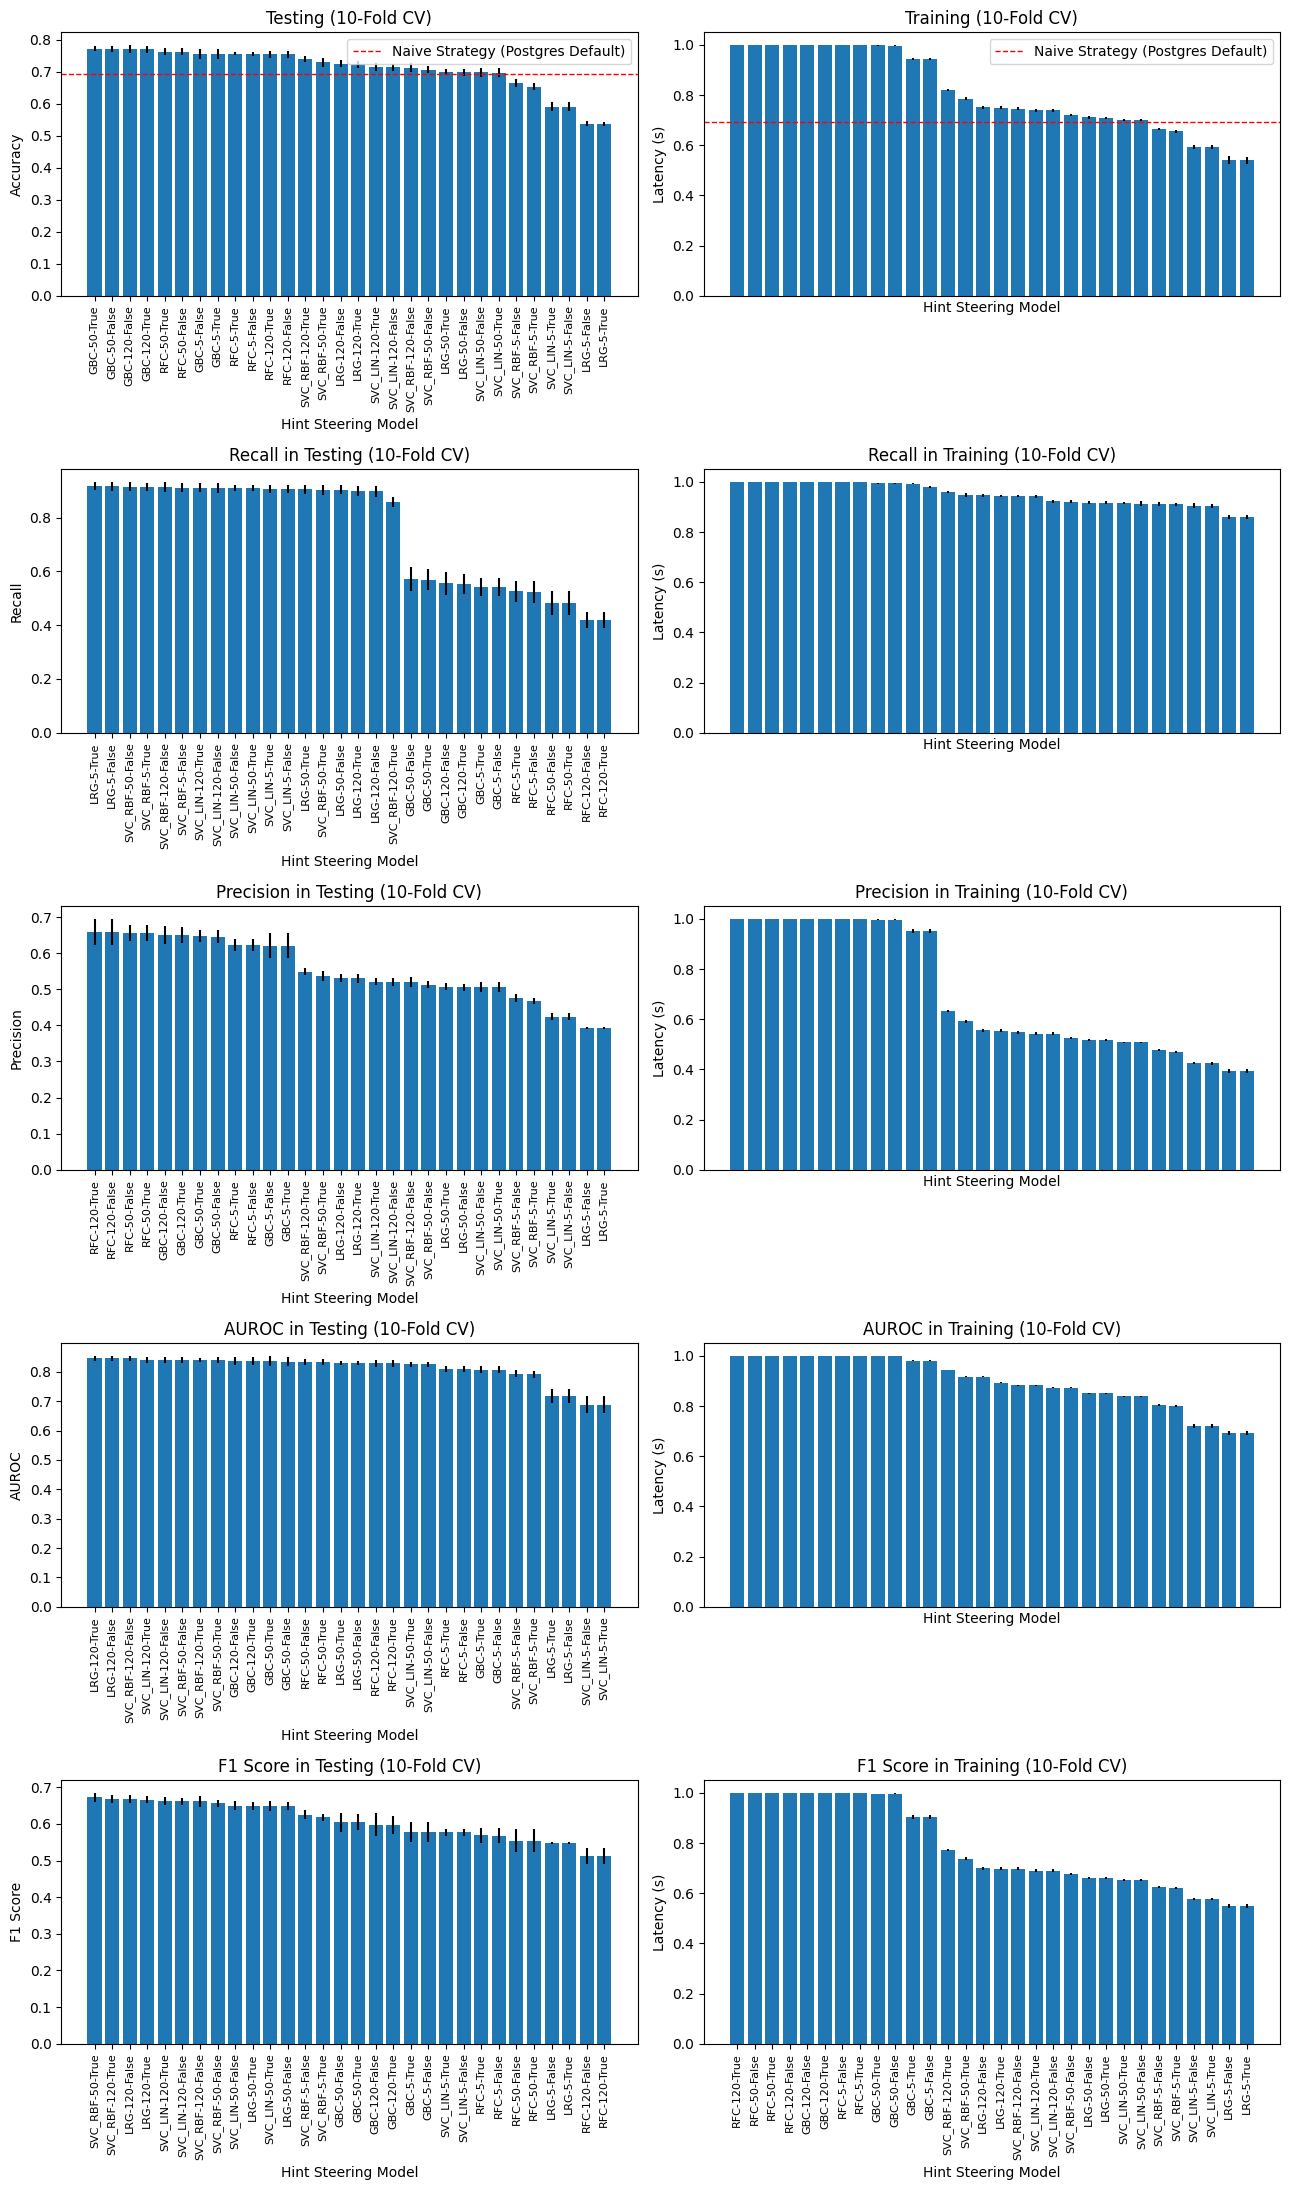

In [15]:
fig, axs = plt.subplots(5,2, figsize=(13,22))

# ------- Testing ------- #
# accuracy
axs[0][0].bar(
    data=model_performances.sort_values(by='model_test_accuracy_mean', ascending=False),
    x='name',
    height='model_test_accuracy_mean',
    yerr='model_test_accuracy_std',
)
axs[0][0].set_xticklabels(axs[0][0].get_xticklabels(), rotation=90, fontdict={'fontsize': '8'})
axs[0][0].set_ylabel('Accuracy')
axs[0][0].set_xlabel('Hint Steering Model')
axs[0][0].set_title('Testing (10-Fold CV)')
axs[0][0].axhline(
    y=model_performances.apriori_test_distribution_mean.iloc[0],
    color='red',
    ls='--',
    lw=1
)
axs[0][0].legend([
    "Naive Strategy (Postgres Default)"
])

# recall
axs[1][0].bar(
    data=model_performances.sort_values(by='model_test_recall_mean', ascending=False),
    x='name',
    height='model_test_recall_mean',
    yerr='model_test_recall_std',
)
axs[1][0].set_xticklabels(axs[1][0].get_xticklabels(), rotation=90, fontdict={'fontsize': '8'})
axs[1][0].set_ylabel('Recall')
axs[1][0].set_xlabel('Hint Steering Model')
axs[1][0].set_title('Recall in Testing (10-Fold CV)')

# precision
axs[2][0].bar(
    data=model_performances.sort_values(by='model_test_precision_mean', ascending=False),
    x='name',
    height='model_test_precision_mean',
    yerr='model_test_precision_std',
)
axs[2][0].set_xticklabels(axs[2][0].get_xticklabels(), rotation=90, fontdict={'fontsize': '8'})
axs[2][0].set_ylabel('Precision')
axs[2][0].set_xlabel('Hint Steering Model')
axs[2][0].set_title('Precision in Testing (10-Fold CV)')

# auroc
axs[3][0].bar(
    data=model_performances.sort_values(by='model_test_auroc_mean', ascending=False),
    x='name',
    height='model_test_auroc_mean',
    yerr='model_test_auroc_std',
)
axs[3][0].set_xticklabels(axs[3][0].get_xticklabels(), rotation=90, fontdict={'fontsize': '8'})
axs[3][0].set_ylabel('AUROC')
axs[3][0].set_xlabel('Hint Steering Model')
axs[3][0].set_title('AUROC in Testing (10-Fold CV)')

# f1 score
axs[4][0].bar(
    data=model_performances.sort_values(by='model_test_f1score_mean', ascending=False),
    x='name',
    height='model_test_f1score_mean',
    yerr='model_test_f1score_std',
)
axs[4][0].set_xticklabels(axs[4][0].get_xticklabels(), rotation=90, fontdict={'fontsize': '8'})
axs[4][0].set_ylabel('F1 Score')
axs[4][0].set_xlabel('Hint Steering Model')
axs[4][0].set_title('F1 Score in Testing (10-Fold CV)')


# ------- Training ------- #
# accuracy
axs[0][1].bar(
    data=model_performances.sort_values(by='model_train_accuracy_mean', ascending=False),
    x='name',
    height='model_train_accuracy_mean',
    yerr='model_train_accuracy_std',
)
axs[0][1].set_xticklabels(axs[0][1].get_xticklabels(), rotation=90, fontdict={'fontsize': '8'})
axs[0][1].get_xaxis().set_ticks([])
axs[0][1].set_ylabel('Latency (s)')
axs[0][1].set_xlabel('Hint Steering Model')
axs[0][1].set_title('Training (10-Fold CV)')
axs[0][1].axhline(
    y=model_performances.apriori_train_distribution_mean.iloc[0],
    color='red',
    ls='--',
    lw=1
)
axs[0][1].legend([
    "Naive Strategy (Postgres Default)"
])

# recall
axs[1][1].bar(
    data=model_performances.sort_values(by='model_train_recall_mean', ascending=False),
    x='name',
    height='model_train_recall_mean',
    yerr='model_train_recall_std',
)
axs[1][1].set_xticklabels(axs[1][1].get_xticklabels(), rotation=90, fontdict={'fontsize': '8'})
axs[1][1].get_xaxis().set_ticks([])
axs[1][1].set_ylabel('Latency (s)')
axs[1][1].set_xlabel('Hint Steering Model')
axs[1][1].set_title('Recall in Training (10-Fold CV)')

# precision
axs[2][1].bar(
    data=model_performances.sort_values(by='model_train_precision_mean', ascending=False),
    x='name',
    height='model_train_precision_mean',
    yerr='model_train_precision_std',
)
axs[2][1].set_xticklabels(axs[2][1].get_xticklabels(), rotation=90, fontdict={'fontsize': '8'})
axs[2][1].get_xaxis().set_ticks([])
axs[2][1].set_ylabel('Latency (s)')
axs[2][1].set_xlabel('Hint Steering Model')
axs[2][1].set_title('Precision in Training (10-Fold CV)')

# auroc
axs[3][1].bar(
    data=model_performances.sort_values(by='model_train_auroc_mean', ascending=False),
    x='name',
    height='model_train_auroc_mean',
    yerr='model_train_auroc_std',
)
axs[3][1].set_xticklabels(axs[3][1].get_xticklabels(), rotation=90, fontdict={'fontsize': '8'})
axs[3][1].get_xaxis().set_ticks([])
axs[3][1].set_ylabel('Latency (s)')
axs[3][1].set_xlabel('Hint Steering Model')
axs[3][1].set_title('AUROC in Training (10-Fold CV)')

# f1 score
axs[4][1].bar(
    data=model_performances.sort_values(by='model_train_f1score_mean', ascending=False),
    x='name',
    height='model_train_f1score_mean',
    yerr='model_train_f1score_std',
)
axs[4][1].set_xticklabels(axs[4][1].get_xticklabels(), rotation=90, fontdict={'fontsize': '8'})
axs[4][1].set_ylabel('Latency (s)')
axs[4][1].set_xlabel('Hint Steering Model')
axs[4][1].set_title('F1 Score in Training (10-Fold CV)')

plt.tight_layout()
plt.show()

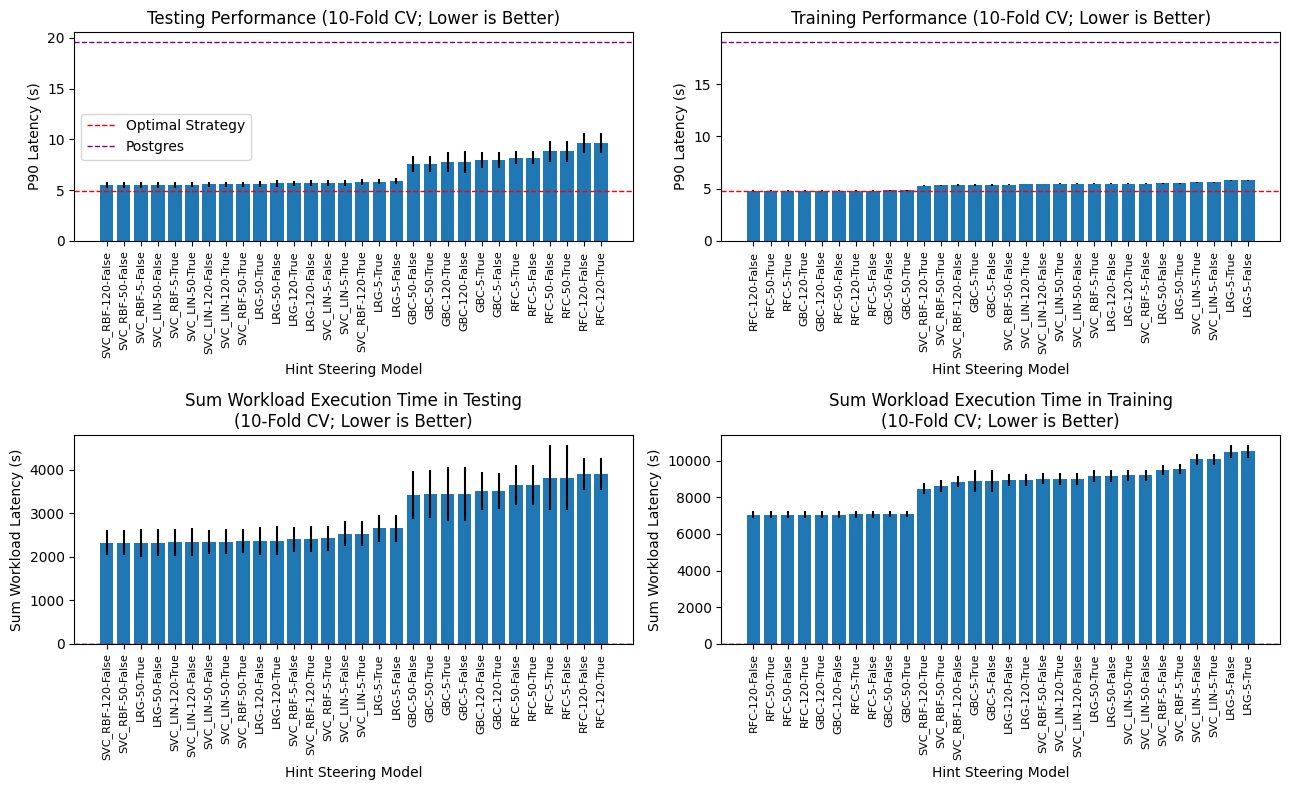

In [17]:
fig, axs = plt.subplots(2,2, figsize=(13,8))

# ------- Testing ------- #
# show p90 comparison
axs[0][0].bar(
    data=model_performances.sort_values(by='model_test_p90_mean'),
    x='name',
    height='model_test_p90_mean',
    yerr='model_test_p90_std',
)
axs[0][0].set_xticklabels(axs[0][0].get_xticklabels(), rotation=90, fontdict={'fontsize': '8'})
axs[0][0].set_ylabel('P90 Latency (s)')
axs[0][0].set_xlabel('Hint Steering Model')
axs[0][0].set_title('Testing Performance (10-Fold CV; Lower is Better)')

# sum workload execution time
axs[1][0].bar(
    data=model_performances.sort_values(by='model_test_workload_mean'),
    x='name',
    height='model_test_workload_mean',
    yerr='model_test_workload_std',
)
axs[1][0].set_xticklabels(axs[1][0].get_xticklabels(), rotation=90, fontdict={'fontsize': '8'})
axs[1][0].set_ylabel('Sum Workload Latency (s)')
axs[1][0].set_xlabel('Hint Steering Model')
axs[1][0].set_title('Sum Workload Execution Time in Testing\n(10-Fold CV; Lower is Better)')


# ------- Training ------- #
# show p90 comparison
axs[0][1].bar(
    data=model_performances.sort_values(by='model_train_p90_mean'),
    x='name',
    height='model_train_p90_mean',
    yerr='model_train_p90_std',
)
# axs[0][1].get_children()[1].set_color('orange')
axs[0][1].set_xticklabels(axs[0][1].get_xticklabels(), rotation=90, fontdict={'fontsize': '8'})
axs[0][1].set_ylabel('P90 Latency (s)')
axs[0][1].set_xlabel('Hint Steering Model')
axs[0][1].set_title('Training Performance (10-Fold CV; Lower is Better)')

# sum workload execution time
axs[1][1].bar(
    data=model_performances.sort_values(by='model_train_workload_mean'),
    x='name',
    height='model_train_workload_mean',
    yerr='model_train_workload_std',
)
axs[1][1].set_xticklabels(axs[1][1].get_xticklabels(), rotation=90, fontdict={'fontsize': '8'})
axs[1][1].set_ylabel('Sum Workload Latency (s)')
axs[1][1].set_xlabel('Hint Steering Model')
axs[1][1].set_title('Sum Workload Execution Time in Training\n(10-Fold CV; Lower is Better)')

for i in range(2):
    for j in range(2):
        if j % 2 == 1:
            axs[i][j].axhline(
                y=np.array(model_performances.train_apriori_p90.iloc[0]).mean() if i == 0 else np.array(model_performances.train_apriori_median.iloc[0]).mean() if i == 1  else np.array(model_performances.train_apriori_workload.iloc[0]).mean(),
                color='red',
                ls='--',
                lw=1
            )
            axs[i][j].axhline(
                y=np.array(model_performances.train_benchmark_p90.iloc[0]).mean() if i == 0 else np.array(model_performances.train_benchmark_median.iloc[0]).mean() if i == 1  else np.array(model_performances.train_benchmark_workload.iloc[0]).mean(),
                color='purple',
                ls='--',
                lw=1
            )
        else:
            axs[i][j].axhline(
                y=np.array(model_performances.test_apriori_p90.iloc[0]).mean() if i == 0 else np.array(model_performances.test_apriori_median.iloc[0]).mean() if i == 1  else np.array(model_performances.test_apriori_workload.iloc[0]).mean(),
                color='red',
                ls='--',
                lw=1
            )
            axs[i][j].axhline(
                y=np.array(model_performances.test_benchmark_p90.iloc[0]).mean() if i == 0 else np.array(model_performances.test_benchmark_median.iloc[0]).mean() if i == 1  else np.array(model_performances.test_benchmark_workload.iloc[0]).mean(),
                color='purple',
                ls='--',
                lw=1
            )
        
        if i == 0 and j == 0:
            axs[i][j].legend([
                "Optimal Strategy",
                "Postgres"
            ])
        else:
            axs[i][j].legend().remove()

plt.tight_layout()
plt.show()

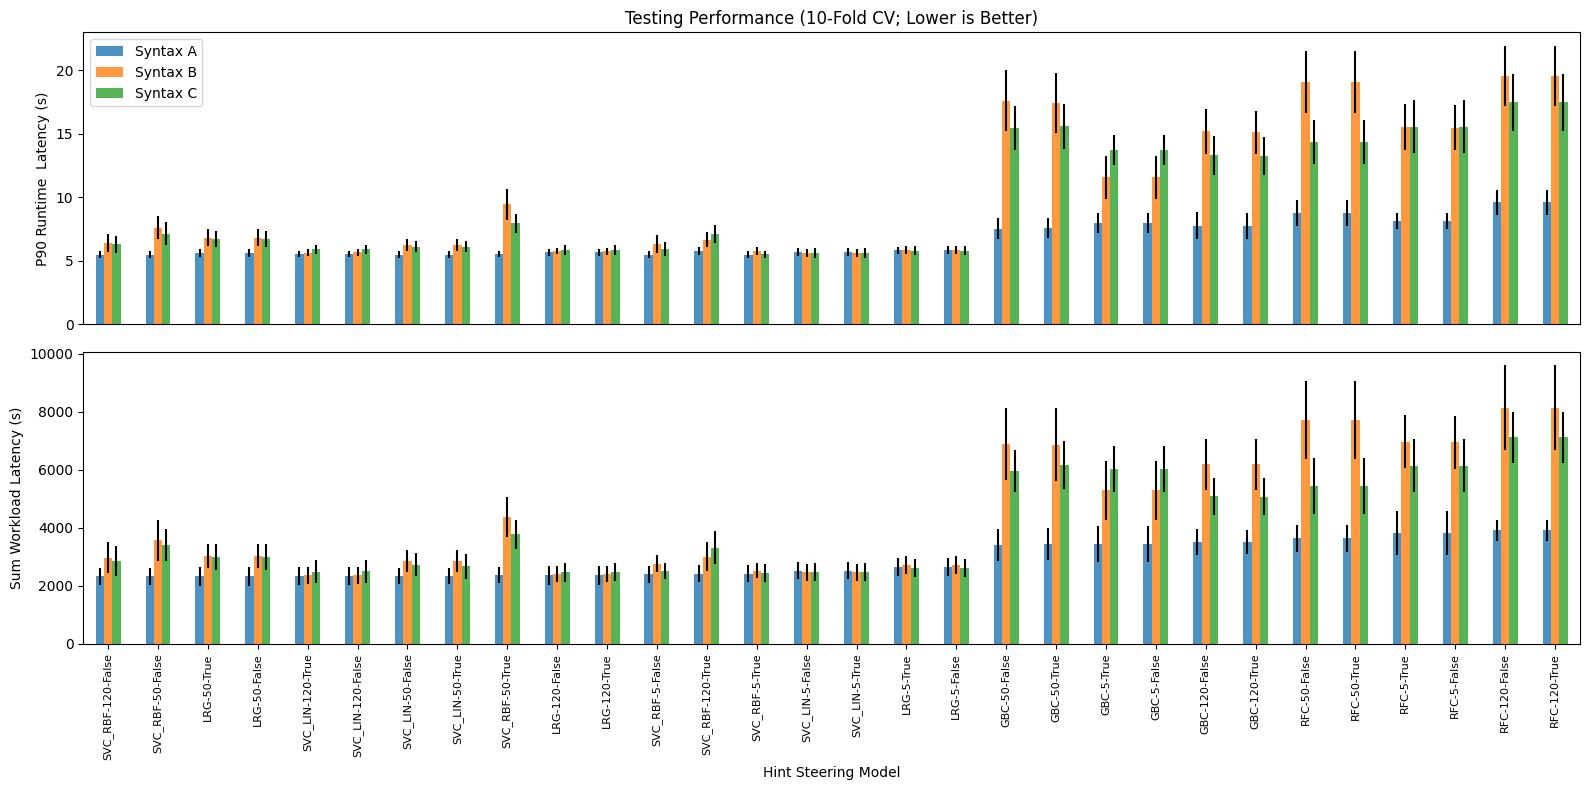

In [19]:
fig, axs = plt.subplots(2,1, figsize=(16,8), sharex=True)

model_performances.set_index('name').sort_values(by='model_test_workload_mean')[[
    'model_test_p90_mean',
    'model_spaced_p90_mean',
    'model_tabbed_p90_mean',
]].plot.bar(
    yerr=model_performances.set_index('name').sort_values(by='model_test_workload_mean')[[
        'model_test_p90_std',
        'model_spaced_p90_std',
        'model_tabbed_p90_std',
    ]].to_numpy().T,
    ax=axs[0],
    alpha=0.8,
    xticks=[]
)
axs[0].set_xticklabels([], rotation=90, fontdict={'fontsize': '8'})
axs[0].get_xaxis().set_visible(False)
axs[0].set_ylabel('P90 Runtime  Latency (s)')
axs[0].set_title('Testing Performance (10-Fold CV; Lower is Better)')

model_performances.set_index('name')[[
    'model_test_workload_mean',
    'model_spaced_workload_mean',
    'model_tabbed_workload_mean',
]].sort_values(by='model_test_workload_mean').plot.bar(
    yerr=model_performances.set_index('name').sort_values(by='model_test_workload_mean')[[
        'model_test_workload_std',
        'model_spaced_workload_std',
        'model_tabbed_workload_std',
    ]].to_numpy().T,
    ax=axs[1],
    alpha=0.8,
)
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90, fontdict={'fontsize': '8'})
axs[1].set_ylabel('Sum Workload Latency (s)')
axs[1].set_xlabel('Hint Steering Model')
# axs[1].set_title('')


for i in range(2):
    if i == 0:
        axs[i].legend([
            "Syntax A",
            "Syntax B",
            "Syntax C"
        ])
    else:
        axs[i].legend().remove()


plt.tight_layout()
plt.show()

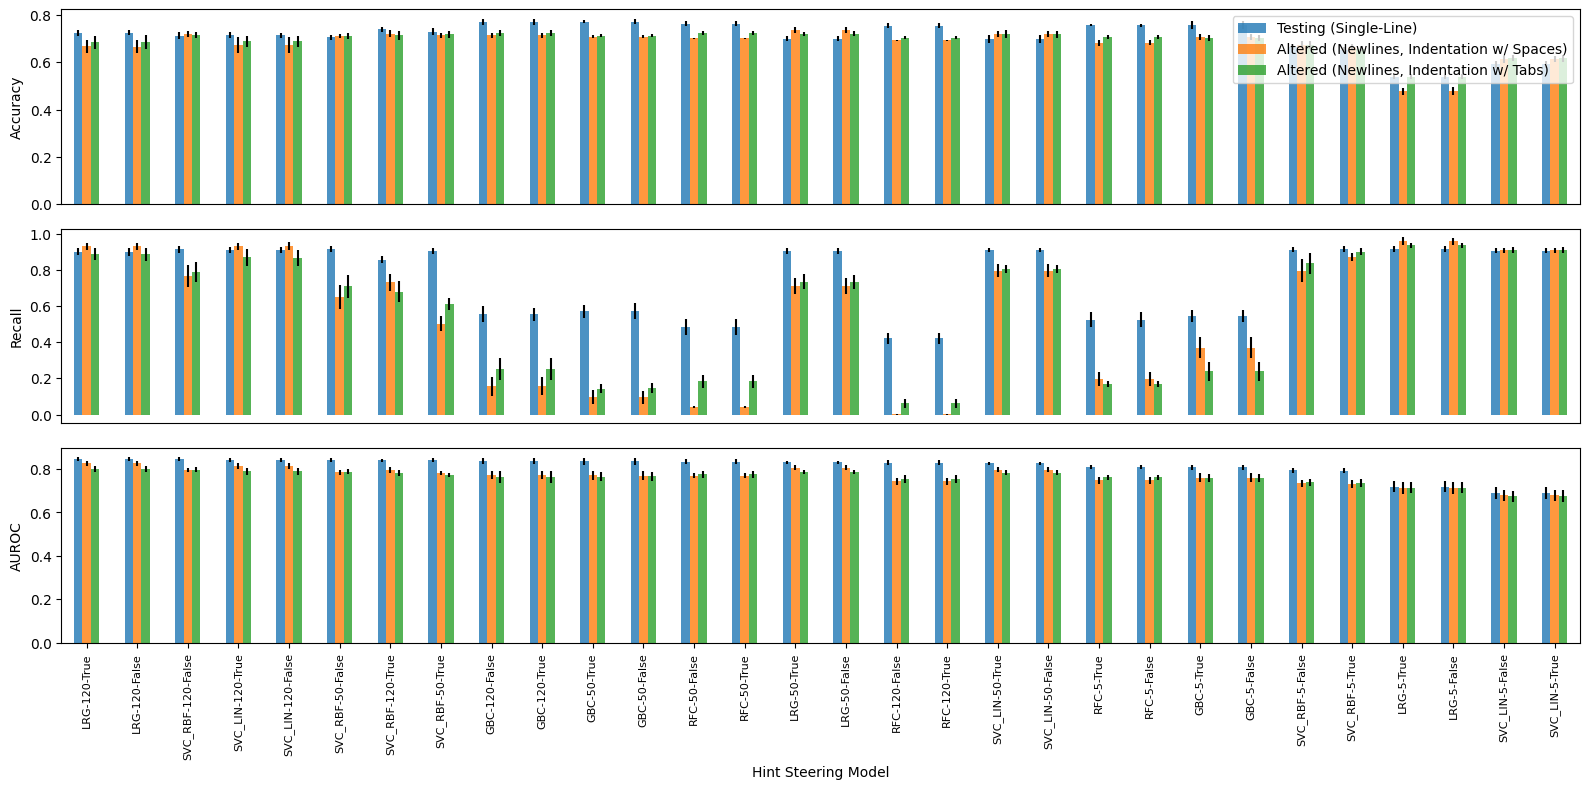

In [20]:
fig, axs = plt.subplots(3,1, figsize=(16,8), sharex=True)

model_performances.set_index('name').sort_values(by='model_test_auroc_mean', ascending=False)[[
    'model_test_accuracy_mean',
    'model_spaced_accuracy_mean',
    'model_tabbed_accuracy_mean',
]].plot.bar(
    yerr=model_performances.set_index('name').sort_values(by='model_test_auroc_mean', ascending=False)[[
        'model_test_accuracy_std',
        'model_spaced_accuracy_std',
        'model_tabbed_accuracy_std',
    ]].to_numpy().T,
    ax=axs[0],
    alpha=0.8,
)
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90, fontdict={'fontsize': '8'})
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Hint Steering Model')
axs[0].set_title('')
axs[0].get_xaxis().set_visible(False)




model_performances.set_index('name').sort_values(by='model_test_auroc_mean', ascending=False)[[
    'model_test_recall_mean',
    'model_spaced_recall_mean',
    'model_tabbed_recall_mean',
]].plot.bar(
    yerr=model_performances.set_index('name').sort_values(by='model_test_auroc_mean', ascending=False)[[
        'model_test_recall_std',
        'model_spaced_recall_std',
        'model_tabbed_recall_std',
    ]].to_numpy().T,
    ax=axs[1],
    alpha=0.8,
)
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90, fontdict={'fontsize': '8'})
axs[1].set_ylabel('Recall')
axs[1].set_xlabel('Hint Steering Model')
axs[1].set_title('')
axs[1].get_xaxis().set_visible(False)


model_performances.set_index('name').sort_values(by='model_test_auroc_mean', ascending=False)[[
    'model_test_auroc_mean',
    'model_spaced_auroc_mean',
    'model_tabbed_auroc_mean',
]].plot.bar(
    yerr=model_performances.set_index('name').sort_values(by='model_test_auroc_mean', ascending=False)[[
        'model_test_auroc_std',
        'model_spaced_auroc_std',
        'model_tabbed_auroc_std',
    ]].to_numpy().T,
    ax=axs[2],
    alpha=0.8,
)
axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=90, fontdict={'fontsize': '8'})
axs[2].set_ylabel('AUROC')
axs[2].set_xlabel('Hint Steering Model')
axs[2].set_title('')


for i in range(3):
    if i == 0:
        axs[i].legend([
            "Testing (Single-Line)",
            "Altered (Newlines, Indentation w/ Spaces)",
            "Altered (Newlines, Indentation w/ Tabs)"
        ])
    else:
        axs[i].legend().remove()


plt.tight_layout()
plt.show()

### Robustness

In [21]:
best_model = model_performances.loc[[model_performances.model_test_workload_mean.idxmin()]].reset_index(drop=True)
best_model.head()

,name,estimator,scale,model_train_accuracy,model_test_accuracy,model_train_recall,model_test_recall,model_train_precision,model_test_precision,model_train_f1score,...,model_spaced_p90_std,model_spaced_median_std,model_tabbed_accuracy_std,model_tabbed_recall_std,model_tabbed_auroc_std,model_tabbed_precision_std,model_tabbed_f1score_std,model_tabbed_workload_std,model_tabbed_p90_std,model_tabbed_median_std
0,SVC_RBF-120-False,"SVC(class_weight={0: 0.4430238902568817, 1: 2....",False,"[0.7588597842835131, 0.7434514637904468, 0.735...","[0.7230769230769231, 0.7138461538461538, 0.715...","[0.9636135508155583, 0.9560853199498118, 0.947...","[0.945, 0.915, 0.915, 0.89, 0.91, 0.915, 0.92,...","[0.5626373626373626, 0.5470208183776023, 0.539...","[0.5279329608938548, 0.5198863636363636, 0.521...","[0.7104532839962997, 0.6958904109589041, 0.687...",...,0.680648,0.057801,0.012292,0.055949,0.011455,0.014145,0.020816,527.422406,0.668989,0.063886


In [30]:
query_types = {'original', 'spaced', 'tabbed'}
cfg = dict(
    estimator = best_model.loc[0,'estimator'],
    pcs = int(best_model.loc[0,'name'].split('-')[1])
)
cfg.update({qt:{qt:{metric:list() for metric in ['p90', 'sum', 'median']} for qt in query_types} for qt in query_types })

for qt in query_types:
    print(f'\n[{datetime.now().isoformat()}] Beginning experiments for {qt.capitalize()}')
    for i, (train_idx, test_idx) in enumerate(StratifiedShuffleSplit(n_splits=k, train_size=p, random_state=RANDOM_SEED).split(original_sql, targets_l)):
        
        
        print(f'[{datetime.now().isoformat()}] CV fold {i+1}')

        if qt == 'original':
            X_train, X_test, y_train, y_test = original_sql[train_idx].numpy(), original_sql[test_idx].numpy(), targets_l[train_idx].numpy(), targets_l[test_idx].numpy()
            X_train = pipeline.fit_transform(X_train)
            X_test = pipeline.transform(X_test)

            X_spaced_test = pipeline.transform(spaced_sql[test_idx].numpy())
            X_tabbed_test = pipeline.transform(tabbed_sql[test_idx].numpy())
        if qt == 'spaced':
            X_train, X_test, y_train, y_test = spaced_sql[train_idx].numpy(), spaced_sql[test_idx].numpy(), targets_l[train_idx].numpy(), targets_l[test_idx].numpy()
            X_train = pipeline.fit_transform(X_train)
            X_test = pipeline.transform(X_test)

            X_spaced_test = pipeline.transform(X[test_idx].numpy())
            X_tabbed_test = pipeline.transform(tabbed_sql[test_idx].numpy())
        if qt == 'tabbed':
            X_train, X_test, y_train, y_test = tabbed_sql[train_idx].numpy(), tabbed_sql[test_idx].numpy(), targets_l[train_idx].numpy(), targets_l[test_idx].numpy()
            X_train = pipeline.fit_transform(X_train)
            X_test = pipeline.transform(X_test)

            X_spaced_test = pipeline.transform(spaced_sql[test_idx].numpy())
            X_tabbed_test = pipeline.transform(X[test_idx].numpy())

        weights = {
            0: ((targets_l[train_idx].type(torch.long) == 1).sum() / (targets_l[train_idx].type(torch.long) == 0).sum()).item(), 
            1: ((targets_l[train_idx].type(torch.long) == 0).sum() / (targets_l[train_idx].type(torch.long) == 1).sum()).item() 
        }

        benchmark_const = torch.LongTensor([0])
        longtail_const = torch.LongTensor([26])

        if hasattr(cfg['estimator'], 'class_weight'):
            cfg['estimator'].class_weight = weights.copy()

        cfg['estimator'].fit(X_train[:,:cfg['pcs']], y_train)
        y_test_pred = cfg['estimator'].predict(X_test[:,:cfg['pcs']])
        y_spaced_pred = cfg['estimator'].predict(X_spaced_test[:,:cfg['pcs']])
        y_tabbed_pred = cfg['estimator'].predict(X_tabbed_test[:,:cfg['pcs']])

        model_original_runtimes = hint_l[test_idx].gather(1, torch.where(torch.Tensor(y_test_pred) > THRESHOLD, longtail_const, benchmark_const).view(-1,1))
        model_original_workload = model_original_runtimes.sum().item()
        model_original_p90 = model_original_runtimes.quantile(0.90).item()
        model_original_median = model_original_runtimes.median().item()
        model_spaced_runtimes = hint_l[test_idx].gather(1, torch.where(torch.Tensor(y_spaced_pred) > THRESHOLD, longtail_const, benchmark_const).view(-1,1))
        model_spaced_workload = model_spaced_runtimes.sum().item()
        model_spaced_p90 = model_spaced_runtimes.quantile(0.90).item()
        model_spaced_median = model_spaced_runtimes.median().item()
        model_tabbed_runtimes = hint_l[test_idx].gather(1, torch.where(torch.Tensor(y_tabbed_pred) > THRESHOLD, longtail_const, benchmark_const).view(-1,1))
        model_tabbed_workload = model_tabbed_runtimes.sum().item()
        model_tabbed_p90 = model_tabbed_runtimes.quantile(0.90).item()
        model_tabbed_median = model_tabbed_runtimes.median().item()

        if qt == 'original':
            cfg[qt]['original']['p90'].append(model_original_p90)
            cfg[qt]['original']['sum'].append(model_original_workload)
            cfg[qt]['original']['median'].append(model_original_median)
            cfg[qt]['spaced']['p90'].append(model_spaced_p90)
            cfg[qt]['spaced']['sum'].append(model_spaced_workload)
            cfg[qt]['spaced']['median'].append(model_spaced_median)
            cfg[qt]['tabbed']['p90'].append(model_tabbed_p90)
            cfg[qt]['tabbed']['sum'].append(model_tabbed_workload)
            cfg[qt]['tabbed']['median'].append(model_tabbed_median)
        if qt == 'spaced':
            cfg[qt]['original']['p90'].append(model_spaced_p90)
            cfg[qt]['original']['sum'].append(model_spaced_workload)
            cfg[qt]['original']['median'].append(model_spaced_median)
            cfg[qt]['spaced']['p90'].append(model_original_p90)
            cfg[qt]['spaced']['sum'].append(model_original_workload)
            cfg[qt]['spaced']['median'].append(model_original_median)
            cfg[qt]['tabbed']['p90'].append(model_tabbed_p90)
            cfg[qt]['tabbed']['sum'].append(model_tabbed_workload)
            cfg[qt]['tabbed']['median'].append(model_tabbed_median)
        if qt == 'tabbed':
            cfg[qt]['original']['p90'].append(model_tabbed_p90)
            cfg[qt]['original']['sum'].append(model_tabbed_workload)
            cfg[qt]['original']['median'].append(model_tabbed_median)
            cfg[qt]['spaced']['p90'].append(model_spaced_p90)
            cfg[qt]['spaced']['sum'].append(model_spaced_workload)
            cfg[qt]['spaced']['median'].append(model_spaced_median)
            cfg[qt]['tabbed']['p90'].append(model_original_p90)
            cfg[qt]['tabbed']['sum'].append(model_original_workload)
            cfg[qt]['tabbed']['median'].append(model_original_median)




[2024-09-22T16:34:00.050591] Beginning experiments for Spaced
[2024-09-22T16:34:00.054451] CV fold 1
[2024-09-22T16:34:07.229521] CV fold 2
[2024-09-22T16:34:14.350212] CV fold 3
[2024-09-22T16:34:19.937074] CV fold 4
[2024-09-22T16:34:26.807433] CV fold 5
[2024-09-22T16:34:32.004957] CV fold 6
[2024-09-22T16:34:37.462232] CV fold 7
[2024-09-22T16:34:42.283178] CV fold 8
[2024-09-22T16:34:46.931881] CV fold 9
[2024-09-22T16:34:52.444644] CV fold 10

[2024-09-22T16:34:57.204055] Beginning experiments for Original
[2024-09-22T16:34:57.204997] CV fold 1
[2024-09-22T16:35:01.860338] CV fold 2
[2024-09-22T16:35:06.947260] CV fold 3
[2024-09-22T16:35:11.690574] CV fold 4
[2024-09-22T16:35:16.662248] CV fold 5
[2024-09-22T16:35:22.034291] CV fold 6
[2024-09-22T16:35:27.784150] CV fold 7
[2024-09-22T16:35:32.805682] CV fold 8
[2024-09-22T16:35:37.576409] CV fold 9
[2024-09-22T16:35:42.187413] CV fold 10

[2024-09-22T16:35:47.916079] Beginning experiments for Tabbed
[2024-09-22T16:35:47.917047

In [31]:
SA_SA_decrease_vs_posgres = 1 - (np.array(cfg['original']['original']['sum']).mean() / np.array(best_model.test_benchmark_workload.iloc[0]).mean())
SA_SB_decrease_vs_posgres = 1 - (np.array(cfg['original']['spaced']['sum']).mean() / np.array(best_model.test_benchmark_workload.iloc[0]).mean())
SA_SC_decrease_vs_posgres = 1 - (np.array(cfg['original']['tabbed']['sum']).mean() / np.array(best_model.test_benchmark_workload.iloc[0]).mean())
SA_SA_increase_vs_optimal = (np.array(cfg['original']['original']['sum']).mean() / np.array(best_model.test_apriori_workload.iloc[0]).mean()) - 1
SA_SB_increase_vs_optimal = (np.array(cfg['original']['spaced']['sum']).mean() / np.array(best_model.test_apriori_workload.iloc[0]).mean()) - 1
SA_SC_increase_vs_optimal = (np.array(cfg['original']['tabbed']['sum']).mean() / np.array(best_model.test_apriori_workload.iloc[0]).mean()) - 1
print(
    f'Trained on Syntax A\n'
    f'[Syntax A] Sum workload decrease vs. PostgreSQL: {SA_SA_decrease_vs_posgres*100:.2f}%\n'
    f'[Syntax B] Sum workload decrease vs. PostgreSQL: {SA_SB_decrease_vs_posgres*100:.2f}%\n'
    f'[Syntax C] Sum workload decrease vs. PostgreSQL: {SA_SC_decrease_vs_posgres*100:.2f}%\n'
    f'[Syntax A] Sum workload increase vs. Optimal: {SA_SA_increase_vs_optimal*100:.2f}%\n'
    f'[Syntax B] Sum workload increase vs. Optimal: {SA_SB_increase_vs_optimal*100:.2f}%\n'
    f'[Syntax C] Sum workload increase vs. Optimal: {SA_SC_increase_vs_optimal*100:.2f}%\n'
)

SB_SA_decrease_vs_posgres = 1 - (np.array(cfg['spaced']['original']['sum']).mean() / np.array(best_model.test_benchmark_workload.iloc[0]).mean())
SB_SB_decrease_vs_posgres = 1 - (np.array(cfg['spaced']['spaced']['sum']).mean() / np.array(best_model.test_benchmark_workload.iloc[0]).mean())
SB_SC_decrease_vs_posgres = 1 - (np.array(cfg['spaced']['tabbed']['sum']).mean() / np.array(best_model.test_benchmark_workload.iloc[0]).mean())
SB_SA_increase_vs_optimal = (np.array(cfg['spaced']['original']['sum']).mean() / np.array(best_model.test_apriori_workload.iloc[0]).mean()) - 1
SB_SB_increase_vs_optimal = (np.array(cfg['spaced']['spaced']['sum']).mean() / np.array(best_model.test_apriori_workload.iloc[0]).mean()) - 1
SB_SC_increase_vs_optimal = (np.array(cfg['spaced']['tabbed']['sum']).mean() / np.array(best_model.test_apriori_workload.iloc[0]).mean()) - 1
print(
    f'\nTrained on Syntax B\n'
    f'[Syntax A] Sum workload decrease vs. PostgreSQL: {SB_SA_decrease_vs_posgres*100:.2f}%\n'
    f'[Syntax B] Sum workload decrease vs. PostgreSQL: {SB_SB_decrease_vs_posgres*100:.2f}%\n'
    f'[Syntax C] Sum workload decrease vs. PostgreSQL: {SB_SC_decrease_vs_posgres*100:.2f}%\n'
    f'[Syntax A] Sum workload increase vs. Optimal: {SB_SA_increase_vs_optimal*100:.2f}%\n'
    f'[Syntax B] Sum workload increase vs. Optimal: {SB_SB_increase_vs_optimal*100:.2f}%\n'
    f'[Syntax C] Sum workload increase vs. Optimal: {SB_SC_increase_vs_optimal*100:.2f}%\n'
)

SC_SA_decrease_vs_posgres = 1 - (np.array(cfg['tabbed']['original']['sum']).mean() / np.array(best_model.test_benchmark_workload.iloc[0]).mean())
SC_SB_decrease_vs_posgres = 1 - (np.array(cfg['tabbed']['spaced']['sum']).mean() / np.array(best_model.test_benchmark_workload.iloc[0]).mean())
SC_SC_decrease_vs_posgres = 1 - (np.array(cfg['tabbed']['tabbed']['sum']).mean() / np.array(best_model.test_benchmark_workload.iloc[0]).mean())
SC_SA_increase_vs_optimal = (np.array(cfg['tabbed']['original']['sum']).mean() / np.array(best_model.test_apriori_workload.iloc[0]).mean()) - 1
SC_SB_increase_vs_optimal = (np.array(cfg['tabbed']['spaced']['sum']).mean() / np.array(best_model.test_apriori_workload.iloc[0]).mean()) - 1
SC_SC_increase_vs_optimal = (np.array(cfg['tabbed']['tabbed']['sum']).mean() / np.array(best_model.test_apriori_workload.iloc[0]).mean()) - 1
print(
    f'\nTrained on Syntax C\n'
    f'[Syntax A] Sum workload decrease vs. PostgreSQL: {SC_SA_decrease_vs_posgres*100:.2f}%\n'
    f'[Syntax B] Sum workload decrease vs. PostgreSQL: {SC_SB_decrease_vs_posgres*100:.2f}%\n'
    f'[Syntax C] Sum workload decrease vs. PostgreSQL: {SC_SC_decrease_vs_posgres*100:.2f}%\n'
    f'[Syntax A] Sum workload increase vs. Optimal: {SC_SA_increase_vs_optimal*100:.2f}%\n'
    f'[Syntax B] Sum workload increase vs. Optimal: {SC_SB_increase_vs_optimal*100:.2f}%\n'
    f'[Syntax C] Sum workload increase vs. Optimal: {SC_SC_increase_vs_optimal*100:.2f}%\n'
)


Trained on Syntax A
[Syntax A] Sum workload decrease vs. PostgreSQL: 71.51%
[Syntax B] Sum workload decrease vs. PostgreSQL: 63.51%
[Syntax C] Sum workload decrease vs. PostgreSQL: 64.94%
[Syntax A] Sum workload increase vs. Optimal: 30.35%
[Syntax B] Sum workload increase vs. Optimal: 66.99%
[Syntax C] Sum workload increase vs. Optimal: 60.43%


Trained on Syntax B
[Syntax A] Sum workload decrease vs. PostgreSQL: 69.90%
[Syntax B] Sum workload decrease vs. PostgreSQL: 71.44%
[Syntax C] Sum workload decrease vs. PostgreSQL: 70.74%
[Syntax A] Sum workload increase vs. Optimal: 37.75%
[Syntax B] Sum workload increase vs. Optimal: 30.68%
[Syntax C] Sum workload increase vs. Optimal: 33.88%


Trained on Syntax C
[Syntax A] Sum workload decrease vs. PostgreSQL: 70.36%
[Syntax B] Sum workload decrease vs. PostgreSQL: 71.47%
[Syntax C] Sum workload decrease vs. PostgreSQL: 71.52%
[Syntax A] Sum workload increase vs. Optimal: 35.65%
[Syntax B] Sum workload increase vs. Optimal: 30.58%
[Syntax 

## Artifacts

### Data & Models

In [45]:
# skops - safer alternative

# metrics from model evaluation
dump(model_performances, './artifacts/alternative_hint/model_evaluation.skops')

# analysis of robustness with best estimator
dump(cfg, './artifacts/alternative_hint/best_estimator_robustness.skops')

# best model - SVM w/ RBF kernel - 120 PCs
dump(cfg['estimator'], './artifacts/alternative_hint/best_estimator.skops')

### Figures

#### Performance

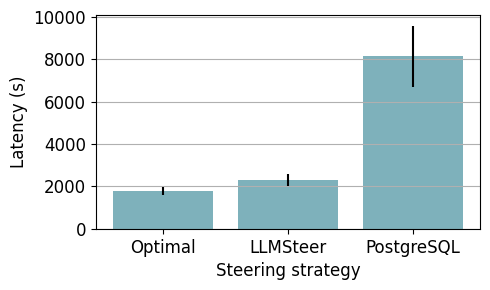

In [37]:
# performance
fig, axs = plt.subplots(figsize=(5,3))
axs.bar(
    x='Optimal',
    height=np.array(best_model.test_apriori_workload.iloc[0]).mean(),
    yerr=np.array(best_model.test_apriori_workload.iloc[0]).std(),
    alpha=0.6,
    color='#287D8EFF',
)
axs.bar(
    x='LLMSteer',
    height=best_model.model_test_workload_mean,
    yerr=best_model.model_test_workload_std,
    alpha=0.6,
    color='#287D8EFF',
)
axs.bar(
    x='PostgreSQL',
    height=np.array(best_model.test_benchmark_workload.iloc[0]).mean(),
    yerr=np.array(best_model.test_benchmark_workload.iloc[0]).std(),
    alpha=0.6,
    color='#287D8EFF',
)

axs.grid(axis='y')
axs.set_ylabel('Latency (s)', fontdict={'size': '12'})
axs.set_xlabel('Steering strategy', fontdict={'size': '12'})
axs.set_xticklabels(axs.get_xticklabels(), rotation=0, fontdict={'fontsize': '12'})
axs.set_yticklabels(axs.get_yticklabels(), rotation=0, fontdict={'fontsize': '12'})


plt.tight_layout()
plt.savefig('./artifacts/alternative_hint/figures/sum.pdf', format='pdf', dpi='figure', bbox_inches='tight')

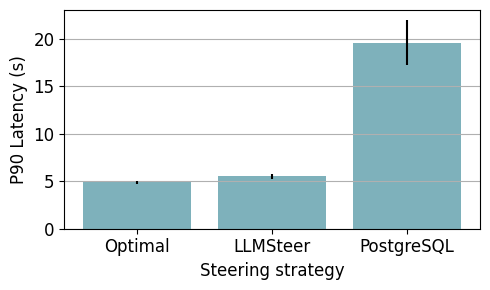

In [38]:
fig, axs = plt.subplots(figsize=(5,3))
axs.bar(
    x='Optimal',
    height=np.array(best_model.test_apriori_p90.iloc[0]).mean(),
    yerr=np.array(best_model.test_apriori_p90.iloc[0]).std(),
    alpha=0.6,
    color='#287D8EFF',
)
axs.bar(
    x='LLMSteer',
    height=best_model.model_test_p90_mean,
    yerr=best_model.model_test_p90_std,
    alpha=0.6,
    color='#287D8EFF',
)
axs.bar(
    x='PostgreSQL',
    height=np.array(best_model.test_benchmark_p90.iloc[0]).mean(),
    yerr=np.array(best_model.test_benchmark_p90.iloc[0]).std(),
    alpha=0.6,
    color='#287D8EFF',
)

axs.grid(axis='y')
axs.set_ylabel('P90 Latency (s)', fontdict={'size': '12'})
axs.set_xlabel('Steering strategy', fontdict={'size': '12'})
axs.set_xticklabels(axs.get_xticklabels(), rotation=0, fontdict={'fontsize': '12'})
axs.set_yticklabels(axs.get_yticklabels(), rotation=0, fontdict={'fontsize': '12'})

plt.tight_layout()
plt.savefig('./artifacts/alternative_hint/figures/p90.pdf', format='pdf', dpi='figure', bbox_inches='tight')

#### Robustness

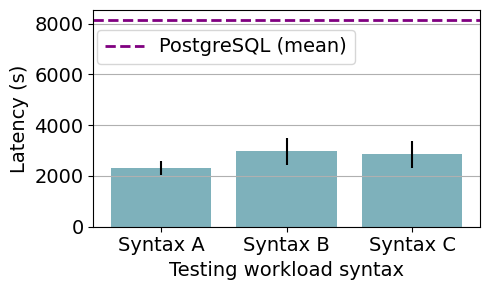

In [39]:
# sum workload - Syntax A trained
fig, axs = plt.subplots(figsize=(5,3))
axs.bar(
    x='Syntax A',
    height=np.array(cfg['original']['original']['sum']).mean(),
    yerr=np.array(cfg['original']['original']['sum']).std(),
    alpha=0.6,
    color='#287D8EFF',
)
axs.bar(
    x='Syntax B',
    height=np.array(cfg['original']['spaced']['sum']).mean(),
    yerr=np.array(cfg['original']['spaced']['sum']).std(),
    alpha=0.6,
    color='#287D8EFF',
)
axs.bar(
    x='Syntax C',
    height=np.array(cfg['original']['tabbed']['sum']).mean(),
    yerr=np.array(cfg['original']['tabbed']['sum']).std(),
    alpha=0.6,
    color='#287D8EFF',
)

axs.axhline(
    y=np.array(best_model.test_benchmark_workload.iloc[0]).mean(),
    color='purple',
    ls='--',
    lw=2,
)
axs.legend(['PostgreSQL (mean)'], loc=(0.01,0.75), fontsize=14)

axs.grid(axis='y')
axs.set_ylabel('Latency (s)', fontdict={'size': '14'})
axs.set_xlabel('Testing workload syntax', fontdict={'size': '14'})
axs.set_xticklabels(axs.get_xticklabels(), rotation=0, fontdict={'fontsize': '14'})
axs.set_yticklabels(axs.get_yticklabels(), rotation=0, fontdict={'fontsize': '14'})

plt.tight_layout()
plt.savefig('./artifacts/alternative_hint/figures/syntaxA_sum.pdf', format='pdf', dpi='figure', bbox_inches='tight')

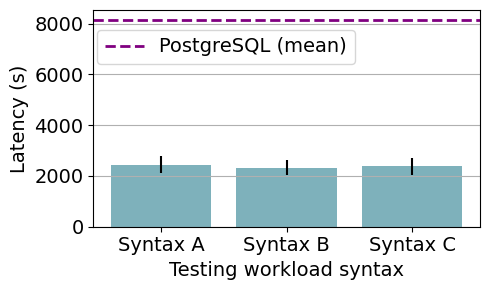

In [40]:
# sum workload - Syntax B trained
fig, axs = plt.subplots(figsize=(5,3))
axs.bar(
    x='Syntax A',
    height=np.array(cfg['spaced']['original']['sum']).mean(),
    yerr=np.array(cfg['spaced']['original']['sum']).std(),
    alpha=0.6,
    color='#287D8EFF',
)
axs.bar(
    x='Syntax B',
    height=np.array(cfg['spaced']['spaced']['sum']).mean(),
    yerr=np.array(cfg['spaced']['spaced']['sum']).std(),
    alpha=0.6,
    color='#287D8EFF',
)
axs.bar(
    x='Syntax C',
    height=np.array(cfg['spaced']['tabbed']['sum']).mean(),
    yerr=np.array(cfg['spaced']['tabbed']['sum']).std(),
    alpha=0.6,
    color='#287D8EFF',
)

axs.axhline(
    y=np.array(best_model.test_benchmark_workload.iloc[0]).mean(),
    color='purple',
    ls='--',
    lw=2,
)
axs.legend(['PostgreSQL (mean)'], loc=(0.01,0.75), fontsize=14)

axs.grid(axis='y')
axs.set_ylabel('Latency (s)', fontdict={'size': '14'})
axs.set_xlabel('Testing workload syntax', fontdict={'size': '14'})
axs.set_xticklabels(axs.get_xticklabels(), rotation=0, fontdict={'fontsize': '14'})
axs.set_yticklabels(axs.get_yticklabels(), rotation=0, fontdict={'fontsize': '14'})

plt.tight_layout()
plt.savefig('./artifacts/alternative_hint/figures/syntaxB_sum.pdf', format='pdf', dpi='figure', bbox_inches='tight')

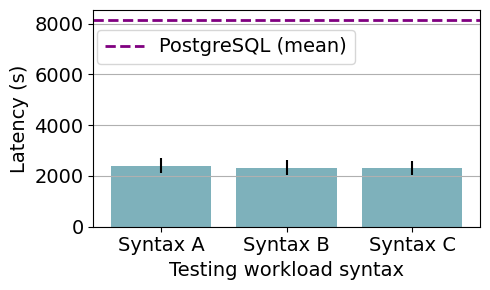

In [41]:
# sum workload - Syntax C trained
fig, axs = plt.subplots(figsize=(5,3))
axs.bar(
    x='Syntax A',
    height=np.array(cfg['tabbed']['original']['sum']).mean(),
    yerr=np.array(cfg['tabbed']['original']['sum']).std(),
    alpha=0.6,
    color='#287D8EFF',
)
axs.bar(
    x='Syntax B',
    height=np.array(cfg['tabbed']['spaced']['sum']).mean(),
    yerr=np.array(cfg['tabbed']['spaced']['sum']).std(),
    alpha=0.6,
    color='#287D8EFF',
)
axs.bar(
    x='Syntax C',
    height=np.array(cfg['tabbed']['tabbed']['sum']).mean(),
    yerr=np.array(cfg['tabbed']['tabbed']['sum']).std(),
    alpha=0.6,
    color='#287D8EFF',
)

axs.axhline(
    y=np.array(best_model.test_benchmark_workload.iloc[0]).mean(),
    color='purple',
    ls='--',
    lw=2,
)
axs.legend(['PostgreSQL (mean)'], loc=(0.01,0.75), fontsize=14)

axs.grid(axis='y')
axs.set_ylabel('Latency (s)', fontdict={'size': '14'})
axs.set_xlabel('Testing workload syntax', fontdict={'size': '14'})
axs.set_xticklabels(axs.get_xticklabels(), rotation=0, fontdict={'fontsize': '14'})
axs.set_yticklabels(axs.get_yticklabels(), rotation=0, fontdict={'fontsize': '14'})

plt.tight_layout()
plt.savefig('./artifacts/alternative_hint/figures/syntaxC_sum.pdf', format='pdf', dpi='figure', bbox_inches='tight')

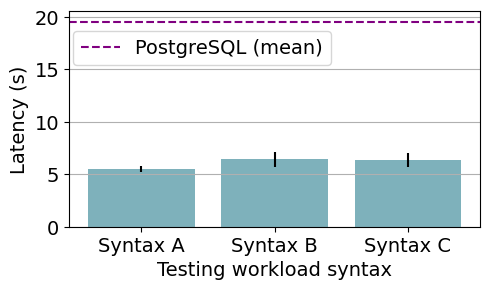

In [42]:
# P90 - Syntax A trained
fig, axs = plt.subplots(figsize=(5,3))
axs.bar(
    x='Syntax A',
    height=np.array(cfg['original']['original']['p90']).mean(),
    yerr=np.array(cfg['original']['original']['p90']).std(),
    alpha=0.6,
    color='#287D8EFF',
)
axs.bar(
    x='Syntax B',
    height=np.array(cfg['original']['spaced']['p90']).mean(),
    yerr=np.array(cfg['original']['spaced']['p90']).std(),
    alpha=0.6,
    color='#287D8EFF',
)
axs.bar(
    x='Syntax C',
    height=np.array(cfg['original']['tabbed']['p90']).mean(),
    yerr=np.array(cfg['original']['tabbed']['p90']).std(),
    alpha=0.6,
    color='#287D8EFF',
)

axs.axhline(
    y=np.array(best_model.test_benchmark_p90.iloc[0]).mean(),
    color='purple',
    ls='--',
    lw=1.5,
)
axs.legend(['PostgreSQL (mean)'], loc=(0.01,0.75), fontsize=14)

axs.grid(axis='y')
axs.set_ylabel('Latency (s)', fontdict={'size': '14'})
axs.set_xlabel('Testing workload syntax', fontdict={'size': '14'})
axs.set_xticklabels(axs.get_xticklabels(), rotation=0, fontdict={'fontsize': '14'})
axs.set_yticklabels(axs.get_yticklabels(), rotation=0, fontdict={'fontsize': '14'})

plt.tight_layout()
plt.savefig('./artifacts/alternative_hint/figures/syntaxA_p90.pdf', format='pdf', dpi='figure', bbox_inches='tight')

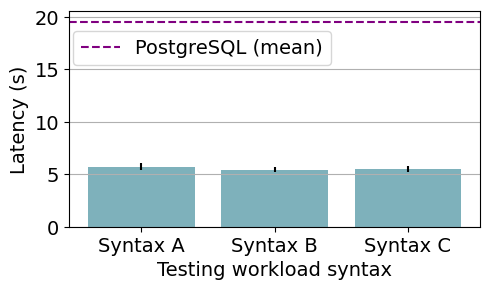

In [43]:
# P90 - Syntax B trained
fig, axs = plt.subplots(figsize=(5,3))
axs.bar(
    x='Syntax A',
    height=np.array(cfg['spaced']['original']['p90']).mean(),
    yerr=np.array(cfg['spaced']['original']['p90']).std(),
    alpha=0.6,
    color='#287D8EFF',
)
axs.bar(
    x='Syntax B',
    height=np.array(cfg['spaced']['spaced']['p90']).mean(),
    yerr=np.array(cfg['spaced']['spaced']['p90']).std(),
    alpha=0.6,
    color='#287D8EFF',
)
axs.bar(
    x='Syntax C',
    height=np.array(cfg['spaced']['tabbed']['p90']).mean(),
    yerr=np.array(cfg['spaced']['tabbed']['p90']).std(),
    alpha=0.6,
    color='#287D8EFF',
)

axs.axhline(
    y=np.array(best_model.test_benchmark_p90.iloc[0]).mean(),
    color='purple',
    ls='--',
    lw=1.5,
)
axs.legend(['PostgreSQL (mean)'], loc=(0.01,0.75), fontsize=14)

axs.grid(axis='y')
axs.set_ylabel('Latency (s)', fontdict={'size': '14'})
axs.set_xlabel('Testing workload syntax', fontdict={'size': '14'})
axs.set_xticklabels(axs.get_xticklabels(), rotation=0, fontdict={'fontsize': '14'})
axs.set_yticklabels(axs.get_yticklabels(), rotation=0, fontdict={'fontsize': '14'})

plt.tight_layout()
plt.savefig('./artifacts/alternative_hint/figures/syntaxB_p90.pdf', format='pdf', dpi='figure', bbox_inches='tight')

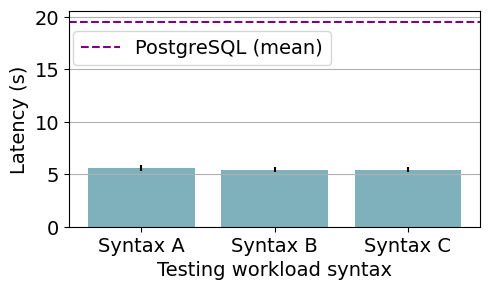

In [46]:
# P90 - Syntax C trained
fig, axs = plt.subplots(figsize=(5,3))
axs.bar(
    x='Syntax A',
    height=np.array(cfg['tabbed']['original']['p90']).mean(),
    yerr=np.array(cfg['tabbed']['original']['p90']).std(),
    alpha=0.6,
    color='#287D8EFF',
)
axs.bar(
    x='Syntax B',
    height=np.array(cfg['tabbed']['spaced']['p90']).mean(),
    yerr=np.array(cfg['tabbed']['spaced']['p90']).std(),
    alpha=0.6,
    color='#287D8EFF',
)
axs.bar(
    x='Syntax C',
    height=np.array(cfg['tabbed']['tabbed']['p90']).mean(),
    yerr=np.array(cfg['tabbed']['tabbed']['p90']).std(),
    alpha=0.6,
    color='#287D8EFF',
)

axs.axhline(
    y=np.array(best_model.test_benchmark_p90.iloc[0]).mean(),
    color='purple',
    ls='--',
    lw=1.5,
)
axs.legend(['PostgreSQL (mean)'], loc=(0.01,0.75), fontsize=14)

axs.grid(axis='y')
axs.set_ylabel('Latency (s)', fontdict={'size': '14'})
axs.set_xlabel('Testing workload syntax', fontdict={'size': '14'})
axs.set_xticklabels(axs.get_xticklabels(), rotation=0, fontdict={'fontsize': '14'})
axs.set_yticklabels(axs.get_yticklabels(), rotation=0, fontdict={'fontsize': '14'})

plt.tight_layout()
plt.savefig('./artifacts/alternative_hint/figures/syntaxC_p90.pdf', format='pdf', dpi='figure', bbox_inches='tight')

## LLMSteer All Hints

In [58]:
results_df = pd.concat([
    pd.DataFrame(torch.load('./artifacts/all_hints/LLMSteer_FNN_LN_model_results.pt',)),
    pd.DataFrame(torch.load('./artifacts/all_hints/LLMSteer_FNN_RG_model_results.pt')),
]).reset_index(drop=True)

results_df['train_workload_mean'] = results_df.train_workload_time.apply(lambda x: torch.Tensor(x).mean())
results_df['train_opt_delta_mean'] = results_df.train_opt_delta.apply(lambda x: torch.Tensor(x).mean())
results_df['train_bench_delta_mean'] = results_df.train_benchmark_delta.apply(lambda x: torch.Tensor(x).mean())
results_df['test_workload_mean'] = results_df.test_workload_time.apply(lambda x: torch.Tensor(x).mean())
results_df['test_opt_delta_mean'] = results_df.test_opt_delta.apply(lambda x: torch.Tensor(x).mean())
results_df['test_bench_delta_mean'] = results_df.test_benchmark_delta.apply(lambda x: torch.Tensor(x).mean())
results_df['train_workload_sd'] = results_df.train_workload_time.apply(lambda x: torch.Tensor(x).std())
results_df['train_opt_delta_sd'] = results_df.train_opt_delta.apply(lambda x: torch.Tensor(x).std())
results_df['train_bench_delta_sd'] = results_df.train_benchmark_delta.apply(lambda x: torch.Tensor(x).std())
results_df['test_workload_sd'] = results_df.test_workload_time.apply(lambda x: torch.Tensor(x).std())
results_df['test_opt_delta_sd'] = results_df.test_opt_delta.apply(lambda x: torch.Tensor(x).std())
results_df['test_bench_delta_sd'] = results_df.test_benchmark_delta.apply(lambda x: torch.Tensor(x).std())
results_df['model'] = results_df.apply(lambda row: f"{row['model_name'].replace('Binary', 'B')}_PC{row['PCs']}_{str(row['post_process'])}", axis=1)

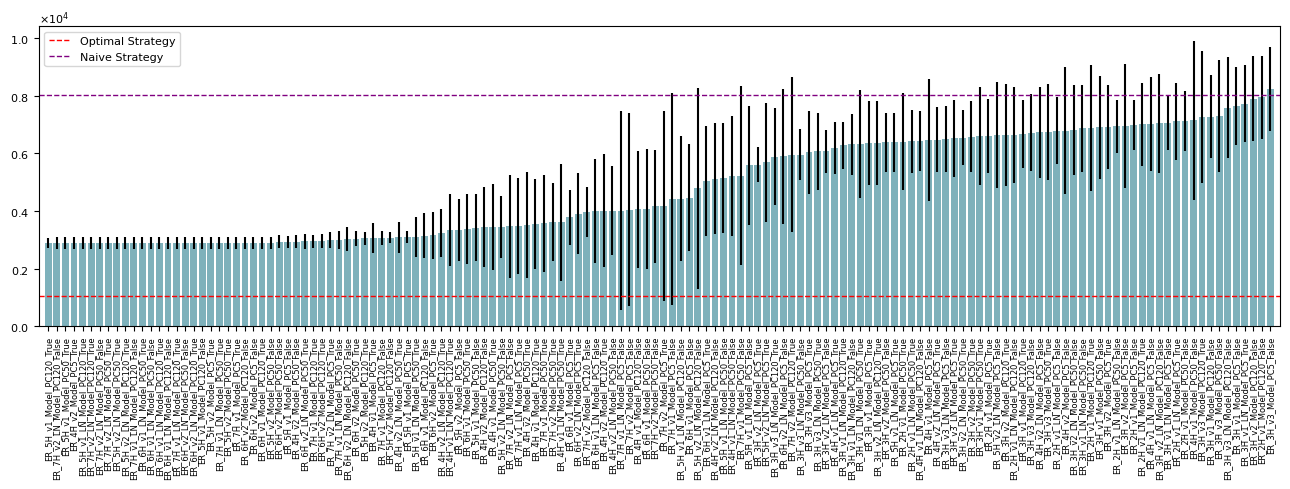

In [49]:
fig, axs = plt.subplots(figsize=(13,5))
axs.bar(
    data = results_df.sort_values(by=['test_workload_mean'], ascending=[True]),
    x = 'model', 
    height = 'test_workload_mean',
    yerr = 'test_workload_sd',
    color='#287D8EFF',
    alpha=0.6
)
axs.set_xticklabels(axs.get_xticklabels(), rotation=90, fontdict={'fontsize': '6'})
axs.margins(x=0.005, tight=True)
axs.axhline(
    y=(torch.Tensor(results_df.test_workload_time) - torch.Tensor(results_df.test_opt_delta)).mean(),
    color='red',
    ls='--',
    lw=1,
)
axs.axhline(
    y=(torch.Tensor(results_df.test_workload_time) + torch.Tensor(results_df.test_benchmark_delta)).mean(),
    color='purple',
    ls='--',
    lw=1,
)
axs.legend([
    "Optimal Strategy",
    "Naive Strategy",
], loc='upper left', fontsize=8)
axs.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
axs.tick_params(axis='y', labelsize=8)
axs.yaxis.get_offset_text().set_fontsize(8)

plt.tight_layout()
plt.show()

In [59]:
if os.path.exists(f"./artifacts/all_hints/LLMSteer_FNN_best_model_results.pt"):
        best_model_results = torch.load(f"./artifacts/all_hints/LLMSteer_FNN_best_model_results.pt")
print(f"The distribution of predictions in testing across 10 CV folds is: {dict(Counter(torch.stack(best_model_results['model_preds_test']).argmax(dim=2, keepdim=True).flatten().numpy()))}")

The distribution of predictions in testing across 10 CV folds is: {26: 6490}
